
### Exploration of results 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Further ideas:
- SHAP
- LIME
- Partial PDPs (?)

---
### Using a Machine Learning model for Interpretability

Since I used the Google's API to obtain LLM ratings, most methods concerning LLM interpretability can not be applied. Therefore, as one another of gaining insights into the model's thinking process, for every set of financial statements, that was used in generating the LLM's signal, key financial metrics will be computed. Afterwards, those metrics will be used to model the relation between a given LLM signal and the underlying financials of a model. 
Possible explanatory models:
    - Logistic Regression (Only distinguishing between buy/not buy)
    - Ordered Linear Regression
    - Machine Learning models i.e. Random Forest with additional exploratio methods like SHAP values or feature importance
Since the financial data at hand is abundant, some sort of pre-selection is necessary, to determine important financial metrics. Financial literature will be conisdered for this task.


#### Paper 1: 
Using ordinary least squares and quantile regression, Naknok (2022) modeled how key financial indicators predict firm performance—measured by Earnings Per Share (EPS) and Return on Equity (ROE)—for 100 publicly traded companies in Thailand.
- Price-To-Earnings-Ratio has negative influence (Naknok, S. Page 13)
- Book-To-Market-Ratio has negative influence (Naknok, S. Page 13)
- Interest-Coverage-Ratio has positive influence (Naknok, S. Page 13)
- Firm size has positive influence (Naknok, S. Page 13)

#### Paper 2:
Using Topological Data Analysis (TDA), Dlotko et al. (2019) modeled the complex, non-linear relationships between seven common financial ratios and stock returns, demonstrating that their combined effects are more critical than individual linear influences. Per study design, they do not compute the significance or power of the individual metrics

- Cashflow-to-Price has a positive influence. (Dłotko et al., Page 15) 
- Book-To-Market-Ratio has a negative influence. (Dłotko et al., Page 15) 
- (Log-)Size has a non-linear influence (some small companies with largest, but also smallest returns) . (Dłotko et al., Page 15) 
- Profitability as in Return-to-Equity has a non-linear influence with unclear direction. (Dłotko et al., Page 15) 
- Earnings-to-Price's influence is complex and dependent on other factors . (Dłotko et al., Page 15) 

(- Dividend Yield's influence is dependent on combinations with other factors. (Dłotko et al., Page 15) )

#### Paper 3:
Using a fixed effects panel data model, Agirman & Yilmaz (2018) investigated the predictive power of four key financial ratios on the stock returns of 47 companies listed on the Borsa Istanbul between 2004 and 2014.

- Firm Size has a positive influence. (Agirman & Yilmaz, 2018, Page 6)
- Price-to-Book Ratio has a positive influence. (Agirman & Yilmaz, 2018, Page 6)

(- Dividend Per Share has a positive influence. (Agirman & Yilmaz, 2018, Page 6))

#### Paper 4:

Using panel data analysis, Ahlannisa et al. (2024) examined the impact of four key financial ratios on the firm value of six cosmetics and household goods companies listed on the Indonesian Stock Exchange from 2015 to 2020.

- Return on Assets has a negative influence. (Ahlannisa et al., 2024, Page 8)
- Current Ratio has a positive influence. (Ahlannisa et al., 2024, Page 9)
- Total Asset Turnover has a positive influence. (Ahlannisa et al., 2024, Page 9)

#### Paper 5: 

Using a Multiple Discriminant Analysis (MDA), Altman (1968) investigated the power of five financial ratios to predict corporate bankruptcy. The model was built using a sample of 66 manufacturing corporations (33 bankrupt, 33 non-bankrupt) from the period 1946-1965 [cite: 118-123].

- Working Capital / Total Assets (X1​) has a positive influence (a higher value predicts non-bankruptcy). (Altman, 1968, Table 1, p. 596)
- Retained Earnings / Total Assets (X2​) has a positive influence. (Altman, 1968, Table 1, p. 596)
- EBIT / Total Assets (X3​) has a positive influence. (Altman, 1968, Table 1, p. 596)
- Market Value Equity / Book Value of Total Debt (X4​) has a positive influence. (Altman, 1968, Table 1, p. 596)
- Sales / Total Assets (X5​) has a positive influence. (Altman, 1968, Table 1, p. 596)



#### Paper 6:

Using a portfolio-based analysis, Sloan (1996) investigated whether stock prices fully reflect the information in earnings by separating them into their cash flow and accrual components for U.S. firms from 1962 to 1991. Deshalb argumentiert das Sloan-Paper (1996), dass Gewinne von höherer Qualität sind, wenn sie durch echten Cashflow gedeckt sind und nicht nur durch Accruals (also "Papiergewinne") .

- Accruals (calculated as (Net Income - Operating Cash Flow) / Total Assets) has a negative influence on future stock returns (i.e., firms with high accruals subsequently underperform firms with low accruals).

Further: 
- Debt to Equity Ratio
- Debt to Assets Ratio


In [3]:
labeled_balance_sheets = pd.read_csv("../data/balance_sheets_with_labels.csv", dtype={"CIK": str}, low_memory=False)
labeled_income_statements = pd.read_csv("../data/income_statements_with_labels.csv", dtype={"CIK": str}, low_memory=False)
labeled_cash_flow_statements = pd.read_csv("../data/cash_flow_statements_with_labels.csv", dtype={"CIK": str}, low_memory=False)
# Convert date to period format
labeled_balance_sheets["Date"] = pd.to_datetime(labeled_balance_sheets["Date"]).dt.to_period("M").astype(str)
labeled_income_statements["Date"] = pd.to_datetime(labeled_income_statements["Date"]).dt.to_period("M").astype(str)
labeled_cash_flow_statements["Date"] = pd.to_datetime(labeled_cash_flow_statements["Date"]).dt.to_period("M").astype(str)
# Read in market caps as predictor variable
mcaps= pd.read_csv("../data/sp1500_market_caps.csv", dtype={"cik": str}).rename(columns={"cik": "CIK", "date": "Date", "market_cap": "Market_Cap"})
# Read in stock prices to compute i.e. book to market ratio
prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str}).rename(columns={"cik": "CIK", "date": "Date", "price": "Stock Price", "security": "Security"})

In [4]:
# Subset all CIK and date combinations from all financial statements
all_ciks_and_dates = pd.concat([
    labeled_balance_sheets[["CIK", "Date"]],
    labeled_income_statements[["CIK", "Date"]],
    labeled_cash_flow_statements[["CIK", "Date"]]
]).drop_duplicates()

# Sort values by CIK and Date
all_ciks_and_dates = all_ciks_and_dates.sort_values(by=["CIK", "Date"]).reset_index(drop=True)
all_ciks_and_dates

,CIK,Date
0,0000001750,1999-08
1,0000001750,1999-11
2,0000001750,2000-02
3,0000001750,2000-05
4,0000001750,2000-08
...,...,...
121385,0002023554,2023-03
121386,0002023554,2023-06
121387,0002027317,2023-09
121388,0002027317,2023-12


In [5]:
def compute_all_financial_metrics(balance_sheets, income_statements, cash_flows, mcap_df, stock_prices_df):
    """
    Compute financial metrics for all CIK-Date combinations in bulk (fast vectorized version).
    """
    # 1. Pivot all statements at once (no loops)
    bs_wide = balance_sheets.pivot_table(
        index=["CIK", "Date"],
        columns="position_label",
        values="STD Balance Sheet All",
        aggfunc="first" # This is needed in case there are duplicate entries for the same CIK-Date-position_label combination, then we just take the first one
    ).reset_index()

    is_wide = income_statements.pivot_table(
        index=["CIK", "Date"],
        columns="position_label",
        values="STD Income Statement All",
        aggfunc="first"
    ).reset_index()

    cf_wide = cash_flows.pivot_table(
        index=["CIK", "Date"],
        columns="position_label",
        values="STD Cash Flow All",
        aggfunc="first"
    ).reset_index()

    # 2. Merge all statements with tqdm progress bar
    print("Merging all statements...")
    df1 = bs_wide.merge(is_wide, on=["CIK", "Date"], how="outer")
    df2 = df1.merge(cf_wide, on=["CIK", "Date"], how="outer")
    df3 = df2.merge(mcaps, on=["CIK", "Date"], how="left")
    merged = df3.merge(prices, on=["CIK", "Date"], how="left")
    print("Merge complete.")
    
    # 3. Vectorized safe division
    def safe_div_vec(a, b):
        try:
            return np.where((b == 0) | (b.isna()) | (a.isna()), np.nan, a / b)
        except Exception as e:
            print(f"Error in safe_div_vec: {e}")
            return np.nan

    # 4. Combine FCF columns
    fcf = merged.get("Free Cash Flow to Equity").combine_first(  # combine first: take value from first series if not null, else from second series
        merged.get("Free Operating Cash Flow")
    )
    
    # 5. Compute metrics vectorized
    metrics_df = pd.DataFrame({
        "CIK": merged["CIK"],
        "Date": merged["Date"],
        "price_to_earnings": safe_div_vec(merged.get("Market_Cap"), merged.get("Net Income After Tax")),
        "book_to_market": safe_div_vec(merged.get("Total Shareholders' Equity"), merged.get("Market_Cap")),
        "interest_coverage": safe_div_vec(merged.get("Earnings Before Interest and Taxes"), merged.get("Interest Expense")),
        "market_capitalization": merged.get("Market_Cap"), 
        "cash_flow_to_price": safe_div_vec(fcf, merged.get("Market_Cap")),
        "return_on_equity": safe_div_vec(merged.get("Net Income After Tax"), merged.get("Total Shareholders' Equity")),
        "earnings_to_price": safe_div_vec(merged.get("Net Income After Tax"), merged.get("Market_Cap")),
        "working_capital_to_total_assets": safe_div_vec(
            merged.get("Total Current Assets") - merged.get("Total Current Liabilities"),
            merged.get("Total Assets")
        ),
        "retained_earnings_to_total_assets": safe_div_vec(
            merged.get("Retained Earnings, Total"),
            merged.get("Total Assets")
        ),
        "ebit_to_total_assets": safe_div_vec(
            merged.get("Earnings Before Interest and Taxes"),
            merged.get("Total Assets")
        ),
        "market_cap_to_total_liabilities": safe_div_vec( 
            merged.get("Market_Cap"),
            merged.get("Total Liabilities")
         ),
        "sales_to_assets": safe_div_vec(
            merged.get("Total Revenue"),
            merged.get("Total Assets")
        ),
        "operating_margin": safe_div_vec(merged.get("Earnings Before Interest and Taxes"), merged.get("Total Revenue")),
        "debt_to_equity": safe_div_vec(merged.get("Debt, Total"), merged.get("Total Shareholders' Equity")),
        "debt_to_assets": safe_div_vec(merged.get("Debt, Total"), merged.get("Total Assets"))
    })

    # 6. Round numeric columns
    numeric_cols = metrics_df.columns.difference(["CIK", "Date"])
    metrics_df[numeric_cols] = metrics_df[numeric_cols].round(6)
    metrics_df["Date"] = pd.to_datetime(metrics_df["Date"]).dt.to_period("M").astype(str)

    # 7. Drop NaN rows
    metrics_df = metrics_df.dropna()

    return metrics_df

In [6]:
financial_metrics_df = compute_all_financial_metrics(
    labeled_balance_sheets,
    labeled_income_statements,
    labeled_cash_flow_statements,
    mcaps,
    prices
)
financial_metrics_df

Merging all statements...
Merge complete.


,CIK,Date,price_to_earnings,book_to_market,interest_coverage,market_capitalization,cash_flow_to_price,return_on_equity,earnings_to_price,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,market_cap_to_total_liabilities,sales_to_assets,operating_margin,debt_to_equity,debt_to_assets
2,0000001750,2000-02,58.926278,0.530538,1.728550,6.455374e+08,0.011753,0.031987,0.016970,0.464610,0.278901,0.027423,1.569608,0.361299,0.075900,0.601468,0.273288
3,0000001750,2000-05,150.850617,0.902729,0.723513,3.727519e+08,0.001027,0.007343,0.006629,0.470815,0.285204,0.011141,0.928438,0.304995,0.036529,0.614457,0.280173
4,0000001750,2000-08,95.641222,1.122869,0.824232,3.021306e+08,0.036501,0.009312,0.010456,0.457493,0.282725,0.013205,0.739990,0.323420,0.040828,0.673592,0.305692
5,0000001750,2000-11,65.131269,1.224786,1.001924,2.786316e+08,0.059135,0.012536,0.015354,0.420966,0.276003,0.014824,0.645463,0.273417,0.054217,0.714555,0.315486
6,0000001750,2001-02,67.788112,0.944209,1.146604,3.652423e+08,-0.068976,0.015624,0.014752,0.475257,0.286771,0.016508,0.891155,0.265094,0.062273,0.666264,0.304446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122338,0002005951,2017-03,80.356401,0.457583,3.906977,6.246246e+09,0.026935,0.027196,0.012445,0.102776,0.171693,0.018289,0.902261,0.231774,0.078910,1.306259,0.381709
122339,0002005951,2017-06,65.153228,0.387453,4.318182,7.373483e+09,0.003576,0.039614,0.015348,0.098159,0.174969,0.020644,1.016210,0.228600,0.090304,1.377049,0.389021
122340,0002005951,2017-09,49.309747,0.412983,5.268293,7.413525e+09,0.024399,0.049106,0.020280,0.058647,0.184161,0.023858,0.978988,0.234268,0.101839,1.325617,0.381651
122341,0002005951,2017-12,56.666892,0.401098,5.590909,8.009357e+09,0.002941,0.043997,0.017647,0.048862,0.197335,0.026823,1.055268,0.240749,0.111413,1.248693,0.371349


In [7]:
# Load llm and analyst df from results exploration notebook 1
llm_df = pd.read_csv("../results/llm_rec_df.csv", dtype={"cik": str}, low_memory=False)
analyst_df = pd.read_csv("../results/analyst_rec_df.csv", dtype={"cik": str}, low_memory=False)

# Merge LLM and analyst recommendations with financial metrics
llm_recommendations_final = llm_df.merge(financial_metrics_df, left_on=["cik", "date"],
                                          right_on=["CIK", "Date"], how="inner").drop(columns = ["CIK", "Date"]).sort_values(by=["cik", "date"]).reset_index(drop=True)
analyst_recommendations_final = analyst_df.merge(financial_metrics_df, left_on=["cik", "date"],
                                                  right_on=["CIK", "Date"], how="inner").drop(columns = ["CIK", "Date"]).sort_values(by=["cik", "date"]).reset_index(drop=True)

# Save to CSV
llm_recommendations_final.to_csv("../results/llm_recommendations_with_financial_metrics.csv", index=False)
analyst_recommendations_final.to_csv("../results/analyst_recommendations_with_financial_metrics.csv", index=False)

"The ordinary least square results indicated that both the price earnings ratio and
book-to-market ratio are significantly negative determinants of firm performance. The
interest coverage ratio was a positive determinant of earnings per share. Meanwhile, the
price earnings ratio, book-to-market ratio, and interest coverage ratio were also main
determinants of firm performance in both earnings per share and return on equity in all
quantiles of the firm" (Firm Performance Indicators as a Fundamental Analysis
of Stocks and a Determinant of a Firm’s Operation, 2022)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Define financial metric columns to be used as features (makes subsetting easier later)
financial_metric_cols = [
    # "price_to_earnings",    
    # "book_to_market",
    "interest_coverage",    
    # "market_capitalization",
    # "cash_flow_to_price",
    "return_on_equity",
    "working_capital_to_total_assets",
    "retained_earnings_to_total_assets",
    "ebit_to_total_assets",
    # "market_cap_to_total_liabilities",
    "sales_to_assets",
    "operating_margin",
    "debt_to_equity",
    "debt_to_assets"
]

- LLM recommendations

In [9]:
# Extract features and labels
X_llm = llm_recommendations_final[financial_metric_cols].apply(pd.to_numeric, errors='coerce')
y_llm = llm_recommendations_final["action"]

# Train-test split
X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(
    X_llm, y_llm, test_size=0.2, random_state=184 , stratify=y_llm 
)

# Fit and Predict
rf_llm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_llm.fit(X_train_llm, y_train_llm)
y_pred_llm = rf_llm.predict(X_test_llm)

# Add predictions to dataframe
llm_recommendations_final.loc[X_test_llm.index, "pred_llm"] = y_pred_llm

In [10]:
llm_accuracy = f"{np.round(rf_llm.score(X_test_llm, y_test_llm),4)*100}%"
llm_accuracy

'67.29%'

In [11]:
llm_recommendations_final["pred_llm"].isna().sum()

np.int64(58997)

In [12]:
# Compute confusion matrix with explicit labels
labels = ["sell", "hold", "buy"]
cm_llm = confusion_matrix(y_test_llm, y_pred_llm, labels=labels)

# Convert to DataFrame for readable row/column labels
cm_df_llm = pd.DataFrame(cm_llm, index=[f"Actual {l}" for l in labels], 
                     columns=[f"Predicted {l}" for l in labels])
cm_df_llm["share_correct"] = np.round(np.diag(cm_df_llm) / cm_df_llm.sum(axis=1), 2) # vectorized, as both operations return an array of same length
cm_df_llm

,Predicted sell,Predicted hold,Predicted buy,share_correct
Actual sell,5642,110,1581,0.77
Actual hold,860,108,986,0.06
Actual buy,1178,110,4175,0.76


In [13]:
print(classification_report(y_test_llm, y_pred_llm))
# Precision: Of all instances predicted as a certain class, how many were actually that class?
# Recall: Of all instances that actually belong to a certain class, how many were correctly predicted as that class?
# F1 Score: The harmonic mean of precision and recall, providing a balance between the two.
# Support: The number of actual occurrences of each class in the dataset.

              precision    recall  f1-score   support

         buy       0.62      0.76      0.68      5463
        hold       0.33      0.06      0.09      1954
        sell       0.73      0.77      0.75      7333

    accuracy                           0.67     14750
   macro avg       0.56      0.53      0.51     14750
weighted avg       0.64      0.67      0.64     14750



In [14]:
# Feature importance (computed from training set)
feature_importances_llm = rf_llm.feature_importances_
feature_importance_df_llm = pd.DataFrame({
    "feature": financial_metric_cols,
    "importance": feature_importances_llm
}).sort_values(by="importance", ascending=False)
feature_importance_df_llm

,feature,importance
1,return_on_equity,0.183249
0,interest_coverage,0.156259
4,ebit_to_total_assets,0.112143
6,operating_margin,0.095916
2,working_capital_to_total_assets,0.094460
8,debt_to_assets,0.093352
3,retained_earnings_to_total_assets,0.092887
7,debt_to_equity,0.086656
5,sales_to_assets,0.085079


In [15]:
# Permutation feature importance (applied on test set)
from sklearn.inspection import permutation_importance
perm_importance_llm = permutation_importance(rf_llm, X_test_llm, y_test_llm, n_repeats=30, random_state=42)
perm_importance_df_llm = pd.DataFrame({
    "feature": financial_metric_cols,
    "importance": perm_importance_llm.importances_mean
}).sort_values(by="importance", ascending=False)
perm_importance_df_llm

,feature,importance
1,return_on_equity,0.056795
8,debt_to_assets,0.020470
2,working_capital_to_total_assets,0.016560
0,interest_coverage,0.009896
6,operating_margin,0.007858
4,ebit_to_total_assets,0.005544
7,debt_to_equity,0.004176
3,retained_earnings_to_total_assets,0.001846
5,sales_to_assets,-0.000818


- Analyst recommendations

In [16]:
# Extract and split
X_analyst = analyst_recommendations_final[financial_metric_cols].apply(pd.to_numeric, errors='coerce')
y_analyst = analyst_recommendations_final["action"]

X_train_analyst, X_test_analyst, y_train_analyst, y_test_analyst = train_test_split(
    X_analyst, y_analyst, test_size=0.2, random_state=184, stratify=y_analyst
)

# Fit and Predict
rf_analyst = RandomForestClassifier(n_estimators=100, random_state=42)
rf_analyst.fit(X_train_analyst, y_train_analyst)
y_pred_analyst = rf_analyst.predict(X_test_analyst)

# Align to DF
analyst_recommendations_final.loc[X_test_analyst.index, "pred_analyst"] = y_pred_analyst

In [17]:
analyst_recommendations_final["pred_analyst"].isna().sum()

np.int64(58997)

In [18]:
analyst_accuracy = f"{np.round(rf_analyst.score(X_test_analyst, y_test_analyst),4)*100}%"
analyst_accuracy

'76.92%'

In [19]:
# Compute confusion matrix with explicit labels
labels = ["sell", "hold", "buy"]
cm_analyst = confusion_matrix(y_test_analyst, y_pred_analyst, labels=labels)

# Convert to DataFrame for readable row/column labels
cm_df_analyst = pd.DataFrame(cm_analyst, index=[f"Actual {l}" for l in labels], 
                     columns=[f"Predicted {l}" for l in labels])
cm_df_analyst["share_correct"] = np.round(np.diag(cm_df_analyst) / cm_df_analyst.sum(axis=1), 2) # vectorized, as both operations return an array of same length
cm_df_analyst

,Predicted sell,Predicted hold,Predicted buy,share_correct
Actual sell,13,39,70,0.11
Actual hold,3,1658,2753,0.38
Actual buy,1,538,9675,0.95


In [20]:
print(classification_report(y_test_analyst, y_pred_analyst))
# Precision: Of all instances predicted as a certain class, how many were actually that class?
# Recall: Of all instances that actually belong to a certain class, how many were correctly predicted as that class?
# F1 Score: The harmonic mean of precision and recall, providing a balance between the two.
# Support: The number of actual occurrences of each class in the dataset.

              precision    recall  f1-score   support

         buy       0.77      0.95      0.85     10214
        hold       0.74      0.38      0.50      4414
        sell       0.76      0.11      0.19       122

    accuracy                           0.77     14750
   macro avg       0.76      0.48      0.51     14750
weighted avg       0.76      0.77      0.74     14750



In [21]:
# Feature importance
feature_importances_analyst = rf_analyst.feature_importances_
feature_importance_df_analyst = pd.DataFrame({
    "feature": financial_metric_cols,
    "importance": feature_importances_analyst
}).sort_values(by="importance", ascending=False)
feature_importance_df_analyst

,feature,importance
3,retained_earnings_to_total_assets,0.138018
2,working_capital_to_total_assets,0.119394
5,sales_to_assets,0.114649
8,debt_to_assets,0.108808
7,debt_to_equity,0.107638
0,interest_coverage,0.106400
6,operating_margin,0.104118
1,return_on_equity,0.102148
4,ebit_to_total_assets,0.098826


In [22]:
# Permutation feature importance
from sklearn.inspection import permutation_importance
perm_importance_analyst = permutation_importance(rf_analyst, X_test_analyst, y_test_analyst, n_repeats=30, random_state=42)
perm_importance_df_analyst = pd.DataFrame({
    "feature": financial_metric_cols,
    "importance": perm_importance_analyst.importances_mean
}).sort_values(by="importance", ascending=False)
perm_importance_df_analyst

,feature,importance
3,retained_earnings_to_total_assets,0.072626
5,sales_to_assets,0.047374
2,working_capital_to_total_assets,0.043928
7,debt_to_equity,0.040947
8,debt_to_assets,0.038432
0,interest_coverage,0.037184
4,ebit_to_total_assets,0.034038
6,operating_margin,0.029754
1,return_on_equity,0.021980


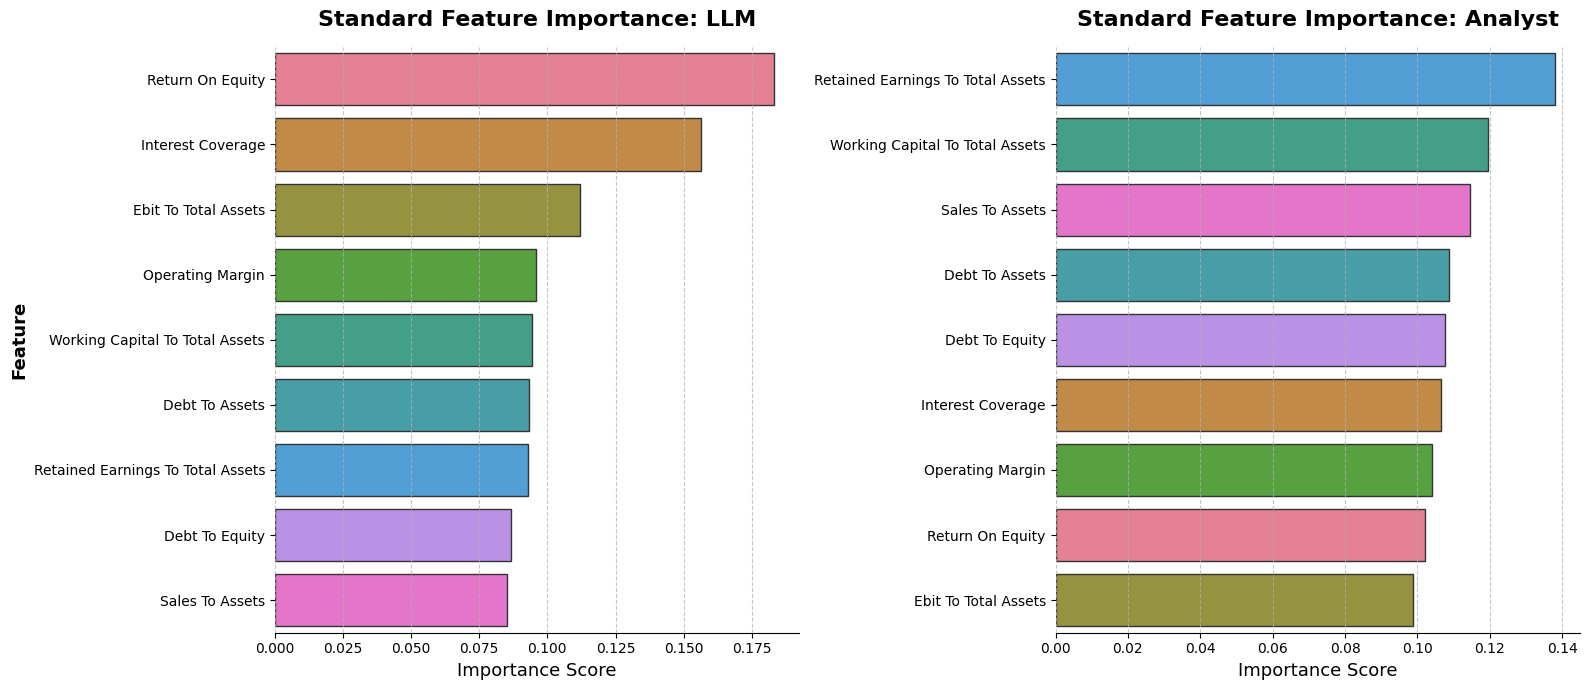

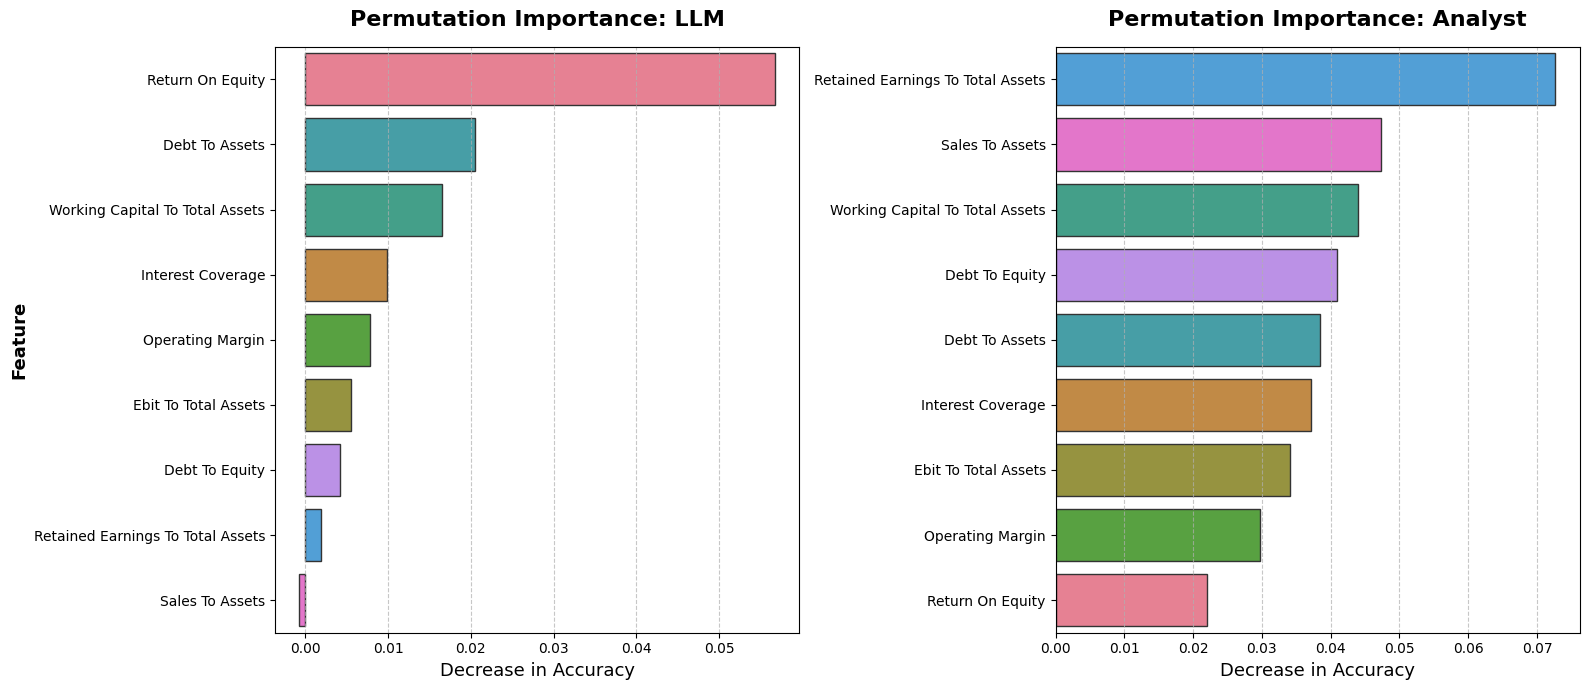

In [23]:
# Color palette to have consistent colors for features across plots
features = feature_importance_df_llm['feature'].unique().tolist()

for df in [feature_importance_df_llm, feature_importance_df_analyst, 
           perm_importance_df_llm, perm_importance_df_analyst]:
    df['feature'] = df['feature'].str.replace('_', ' ').str.title()

features_cleaned = [f.replace('_', ' ').title() for f in features]
feature_to_color = dict(zip(features_cleaned, sns.color_palette("husl", len(features))))

# Plot 1: Standard feature importance comparison
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 7))

# LLM Plot
sns.barplot(x="importance", y="feature", data=feature_importance_df_llm, 
            ax=axes1[0], palette=feature_to_color, hue="feature", legend=False, edgecolor='0.2')
axes1[0].set_title("Standard Feature Importance: LLM", fontsize=16, fontweight='bold', pad=15)
axes1[0].set_ylabel("Feature", fontsize=13, fontweight='bold')
axes1[0].set_xlabel("Importance Score", fontsize=13)
axes1[0].grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(ax=axes1[0], left=True)

# Analyst Plot
sns.barplot(x="importance", y="feature", data=feature_importance_df_analyst, 
            ax=axes1[1], palette=feature_to_color, hue="feature", legend=False, edgecolor='0.2')
axes1[1].set_title("Standard Feature Importance: Analyst", fontsize=16, fontweight='bold', pad=15)
axes1[1].set_ylabel("", fontsize=0) # Removing redundant label on second plot
axes1[1].set_xlabel("Importance Score", fontsize=13)
axes1[1].grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(ax=axes1[1], left=True)
plt.tight_layout()
fig1.savefig("../figures/feature_importance_plots.png", dpi=300)
plt.show()

# Plot 2: Permutation importance comparison
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 7))

# LLM Plot
sns.barplot(x="importance", y="feature", data=perm_importance_df_llm, 
            ax=axes2[0], palette=feature_to_color, hue="feature", legend=False, edgecolor='0.2')
axes2[0].set_title("Permutation Importance: LLM", fontsize=16, fontweight='bold', pad=15)
axes2[0].set_ylabel("Feature", fontsize=13, fontweight='bold')
axes2[0].set_xlabel("Decrease in Accuracy", fontsize=13)
axes2[0].grid(axis='x', linestyle='--', alpha=0.7)

# Analyst Plot
sns.barplot(x="importance", y="feature", data=perm_importance_df_analyst, 
            ax=axes2[1], palette=feature_to_color, hue="feature", legend=False, edgecolor='0.2')
axes2[1].set_title("Permutation Importance: Analyst", fontsize=16, fontweight='bold', pad=15)
axes2[1].set_ylabel("", fontsize=0)
axes2[1].set_xlabel("Decrease in Accuracy", fontsize=13)
axes2[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
fig2.savefig("../figures/permutation_importance_plots.png", dpi=300)
plt.show()

---

## SHAP values

In [24]:
import shap
from functions.plotting import plot_multiclass_shap, plot_waterfall
explainer_llm = shap.TreeExplainer(rf_llm)
shap_values_llm = explainer_llm.shap_values(X_test_llm)
# Save LLM values
np.save("../data/shap_values_llm.npy", np.array(shap_values_llm, dtype=object))

- Global importance Bar Chart

In [25]:
explainer_analyst = shap.TreeExplainer(rf_analyst) 
shap_values_analyst = explainer_analyst.shap_values(X_test_analyst)

In [136]:
from matplotlib.colors import ListedColormap

def plot_multiclass_shap(shap_values, X_data, model_classes, input_title):

    # Prepare Data
    X_cleaned = X_data.copy()
    X_cleaned.columns = [c.replace('_', ' ').title() for c in X_cleaned.columns]
    
    # Capitalize and format class labels
    class_labels = [str(cls).capitalize() for cls in model_classes]
    if input_title == "Feature Attribution Gemini Decisions": 
        color_map =  ListedColormap(sns.color_palette(["#C62828", "#2E7D32", "#78909C"]).as_hex())
    else: 
        color_map = ListedColormap(sns.color_palette(["#2E7D32", "#78909C", "#C62828"]).as_hex())
    
    # 4. Create Figure
    fig, ax = plt.subplots(figsize=(11, 7))
    
    # SHAP Plot
    shap.summary_plot(
        shap_values, 
        X_cleaned, 
        plot_type="bar", 
        class_names=class_labels,
        show=False,
        color = color_map
    )

    # 6. Refined Styling
    # Center the title and increase padding
    plt.title(input_title, 
              fontsize=14, 
              pad=20, 
              x = 0.2)

    # Add a light vertical grid to help compare bar lengths
    ax.xaxis.grid(True, linestyle='--', alpha=0.6, zorder=0)
    ax.set_axisbelow(True)
    
    # Clean up labels
    plt.xlabel("Mean |SHAP Value| (Average impact on model output magnitude)", 
               fontsize=12, labelpad=15, x = 0.2)
    plt.ylabel("Financial Metrics", fontsize=12, labelpad=15)
    plt.yticks(fontsize=10)

    # 7. Final Polish and Save
    plt.tight_layout()
    
    # Save with high resolution for print
    filename = f"SHAP_Global_{input_title.replace(' ', '_')}.png"
    plt.savefig(f"../figures/{filename}", dpi=400, bbox_inches='tight')
    plt.show()


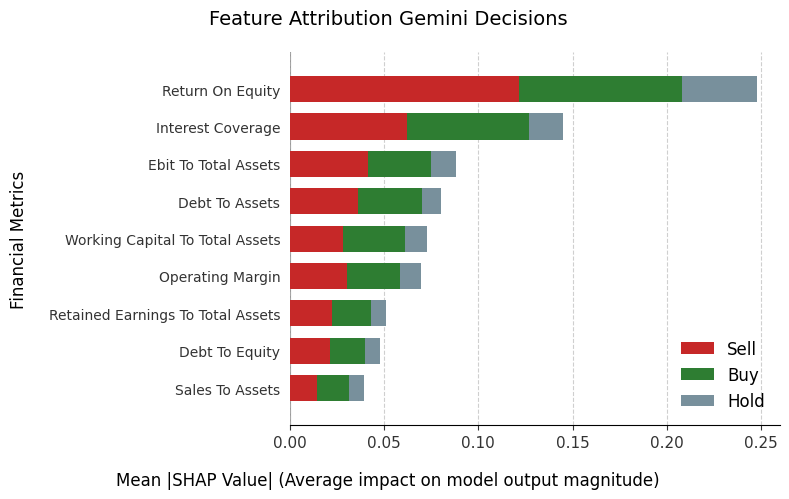

In [137]:
plot_multiclass_shap(shap_values_llm, X_test_llm, rf_llm.classes_, "Feature Attribution Gemini Decisions")

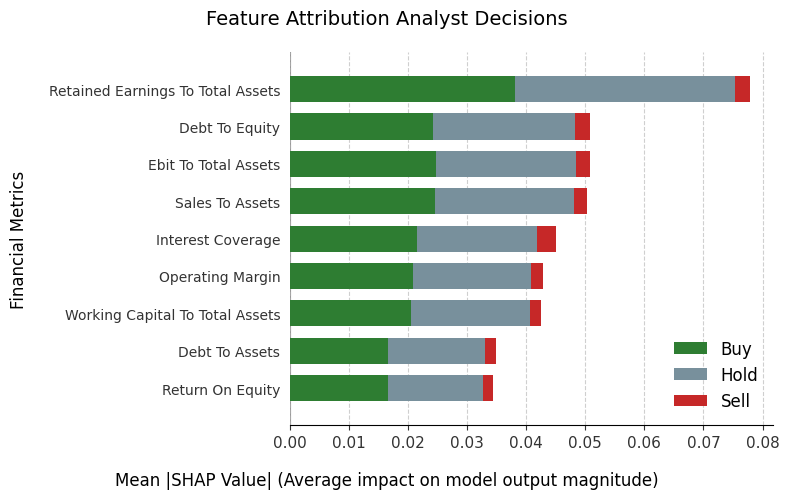

In [138]:
plot_multiclass_shap(shap_values_analyst, X_test_analyst, rf_analyst.classes_, "Feature Attribution Analyst Decisions")

In [ ]:
# Save Analyst values
np.save("../data/shap_values_analyst.npy", np.array(shap_values_analyst, dtype=object))

- Analyzing single data points, with disagreeing trading recommendations

In [ ]:
# Merge LLM and analyst recommendations with financial metrics
merged_df = llm_recommendations_final.merge(
    analyst_recommendations_final, 
    on = ["cik", "date"],
    suffixes=('_llm', '_analyst'),
    how = 'left'
)

# Subset for non entry llm and analyst rating
merged_df = merged_df[~merged_df["pred_llm"].isna() & ~merged_df["pred_analyst"].isna()].drop_duplicates(subset = ["cik", "date"])

In [ ]:
# LLM buy combinations
llm_buy_analyst_buy_sample = merged_df[(merged_df["action_llm"] == "buy") & (merged_df["pred_llm"] == "buy") &
                                       (merged_df["action_analyst"] == "buy") & (merged_df["pred_analyst"] == "buy")].sample(n=1, random_state=42)
llm_buy_analyst_hold_sample = merged_df[(merged_df["action_llm"] == "buy") & (merged_df["pred_llm"] == "buy") &
                                        (merged_df["action_analyst"] == "hold") & (merged_df["pred_analyst"] == "hold")].sample(n=1, random_state=42)
llm_buy_analyst_sell_sample = merged_df[(merged_df["action_llm"] == "buy") & (merged_df["pred_llm"] == "buy") &
                                        (merged_df["action_analyst"] == "sell") & (merged_df["pred_analyst"] == "sell")].sample(n=1, random_state=42)

# LLM hold combinations
llm_hold_analyst_buy_sample = merged_df[(merged_df["action_llm"] == "hold") & (merged_df["pred_llm"] == "hold") &
                                        (merged_df["action_analyst"] == "buy") & (merged_df["pred_analyst"] == "buy")].sample(n=1, random_state=42)
llm_hold_analyst_hold_sample = merged_df[(merged_df["action_llm"] == "hold") & (merged_df["pred_llm"] == "hold") &
                                         (merged_df["action_analyst"] == "hold") & (merged_df["pred_analyst"] == "hold")].sample(n=1, random_state=42)
llm_hold_analyst_sell_sample = merged_df[(merged_df["action_llm"] == "hold") & (merged_df["pred_llm"] == "hold") &
                                         (merged_df["action_analyst"] == "sell") & (merged_df["pred_analyst"] == "sell")].sample(n=1, random_state=42)

# LLM sell combinations
llm_sell_analyst_buy_sample = merged_df[(merged_df["action_llm"] == "sell") & (merged_df["pred_llm"] == "sell") &
                                        (merged_df["action_analyst"] == "buy") & (merged_df["pred_analyst"] == "buy")].sample(n=1, random_state=42)
llm_sell_analyst_hold_sample = merged_df[(merged_df["action_llm"] == "sell") & (merged_df["pred_llm"] == "sell") &
                                         (merged_df["action_analyst"] == "hold") & (merged_df["pred_analyst"] == "hold")].sample(n=1, random_state=42)
llm_sell_analyst_sell_sample = merged_df[(merged_df["action_llm"] == "sell") & (merged_df["pred_llm"] == "sell") &
                                         (merged_df["action_analyst"] == "sell") & (merged_df["pred_analyst"] == "sell")].sample(n=1, random_state=42)

# Combine into one df
different_recs = pd.concat([
    llm_buy_analyst_buy_sample,
    llm_buy_analyst_hold_sample,
    llm_buy_analyst_sell_sample,
    llm_hold_analyst_buy_sample,
    llm_hold_analyst_hold_sample,
    llm_hold_analyst_sell_sample,
    llm_sell_analyst_buy_sample,
    llm_sell_analyst_hold_sample,
    llm_sell_analyst_sell_sample
])
different_recs

,cik,date,rating_llm,action_llm,sector_llm,price_to_earnings_llm,book_to_market_llm,interest_coverage_llm,market_capitalization_llm,cash_flow_to_price_llm,...,earnings_to_price_analyst,working_capital_to_total_assets_analyst,retained_earnings_to_total_assets_analyst,ebit_to_total_assets_analyst,market_cap_to_total_liabilities_analyst,sales_to_assets_analyst,operating_margin_analyst,debt_to_equity_analyst,debt_to_assets_analyst,pred_analyst
38245,0000895417,2018-03,buy,buy,Real Estate,123.656924,0.141386,3.413804,7.788160e+09,0.010616,...,0.008087,-0.008145,-0.058467,0.023779,3.008238,0.066417,0.358019,2.033248,0.606731,buy
4762,0000026172,2017-04,buy,buy,Consumer Cyclicals,62.602904,0.294863,23.500000,2.535418e+10,0.012700,...,0.015974,0.223679,0.720545,0.027056,3.107891,0.293527,0.092177,0.260166,0.124408,hold
56360,0001120193,2004-06,buy,buy,Financials,103.375792,0.328353,1.493373,4.946532e+08,0.091650,...,0.009673,0.350764,0.392472,0.010014,0.714131,0.140352,0.071351,1.631562,0.309911,sell
6628,0000039368,2000-05,hold,hold,Basic Materials,30.809844,0.756061,2.629944,5.449337e+08,0.025150,...,0.032457,0.195839,0.354444,0.031220,0.892868,0.342528,0.091146,0.767446,0.309286,buy
22616,0000721371,2018-12,hold,hold,Healthcare,47.288908,0.454765,7.013158,1.328818e+10,0.023480,...,0.021147,0.031313,0.129331,0.013173,0.386071,0.932727,0.014123,1.497435,0.223642,hold
19554,0000310142,2005-06,hold,hold,Basic Materials,61.378700,0.665719,1.719052,9.736503e+08,0.004094,...,0.016292,0.212443,0.522313,0.021745,1.282222,0.187386,0.116042,0.859701,0.395900,sell
75576,0001756262,2022-03,sell,sell,Healthcare,-71.321250,0.079531,-9.759375,7.532950e+08,-0.027027,...,-0.014021,0.689786,-3.653055,-0.075552,11.752239,0.128056,-0.589987,0.589785,0.284933,buy
11646,0000067887,2020-06,sell,sell,Industrials,-146.028612,0.677596,2.369068,1.838500e+09,-0.009008,...,-0.006848,0.289807,0.676087,0.006876,0.916232,0.202174,0.034012,0.800733,0.306708,hold
28365,0000811596,2004-09,sell,sell,Basic Materials,-0.021549,-486.585932,0.804348,3.592171e+06,0.250545,...,-46.406473,0.062738,-1.499408,0.002433,0.001099,0.185322,0.013130,-0.001945,0.002236,sell


seed 184

In [ ]:
# Find data points in original dataframes and add prediction of counterpart model to contrast in plot later on 
llm_shap_samples = llm_recommendations_final.merge(
    different_recs[["cik", "date", "pred_analyst"]], on=["cik", "date"]).sort_values
analyst_shap_samples = analyst_recommendations_final.merge(
    different_recs[["cik", "date", "pred_llm"]], on=["cik", "date"])
# Construct test sets for SHAP (financial metrics only)
llm_shap_input = llm_shap_samples[financial_metric_cols].apply(pd.to_numeric, errors='coerce')
analyst_shap_input = analyst_shap_samples[financial_metric_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
llm_shap_samples

,cik,date,rating,action,sector,price_to_earnings,book_to_market,interest_coverage,market_capitalization,cash_flow_to_price,...,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,market_cap_to_total_liabilities,sales_to_assets,operating_margin,debt_to_equity,debt_to_assets,pred_llm,pred_analyst
0,0000026172,2017-04,buy,buy,Consumer Cyclicals,62.602904,0.294863,23.500000,2.535418e+10,0.012700,...,0.223679,0.720545,0.027056,3.107891,0.293527,0.092177,0.260166,0.124408,buy,hold
1,0000039368,2000-05,hold,hold,Basic Materials,30.809844,0.756061,2.629944,5.449337e+08,0.025150,...,0.195839,0.354444,0.031220,0.892868,0.342528,0.091146,0.767446,0.309286,hold,buy
2,0000067887,2020-06,sell,sell,Industrials,-146.028612,0.677596,2.369068,1.838500e+09,-0.009008,...,0.289807,0.676087,0.006876,0.916232,0.202174,0.034012,0.800733,0.306708,sell,hold
3,0000310142,2005-06,hold,hold,Basic Materials,61.378700,0.665719,1.719052,9.736503e+08,0.004094,...,0.212443,0.522313,0.021745,1.282222,0.187386,0.116042,0.859701,0.395900,hold,sell
4,0000721371,2018-12,hold,hold,Healthcare,47.288908,0.454765,7.013158,1.328818e+10,0.023480,...,0.031313,0.129331,0.013173,0.386071,0.932727,0.014123,1.497435,0.223642,hold,hold
5,0000811596,2004-09,sell,sell,Basic Materials,-0.021549,-486.585932,0.804348,3.592171e+06,0.250545,...,0.062738,-1.499408,0.002433,0.001099,0.185322,0.013130,-0.001945,0.002236,sell,sell
6,0000895417,2018-03,buy,buy,Real Estate,123.656924,0.141386,3.413804,7.788160e+09,0.010616,...,-0.008145,-0.058467,0.023779,3.008238,0.066417,0.358019,2.033248,0.606731,buy,buy
7,0001120193,2004-06,buy,buy,Financials,103.375792,0.328353,1.493373,4.946532e+08,0.091650,...,0.350764,0.392472,0.010014,0.714131,0.140352,0.071351,1.631562,0.309911,buy,sell
8,0001756262,2022-03,sell,sell,Healthcare,-71.321250,0.079531,-9.759375,7.532950e+08,-0.027027,...,0.689786,-3.653055,-0.075552,11.752239,0.128056,-0.589987,0.589785,0.284933,sell,buy


In [ ]:
analyst_shap_input

,interest_coverage,return_on_equity,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,sales_to_assets,operating_margin,debt_to_equity,debt_to_assets
0,23.500000,0.054173,0.223679,0.720545,0.027056,0.293527,0.092177,0.260166,0.124408
1,2.629944,0.042929,0.195839,0.354444,0.031220,0.342528,0.091146,0.767446,0.309286
2,2.369068,-0.010106,0.289807,0.676087,0.006876,0.202174,0.034012,0.800733,0.306708
3,1.719052,0.024473,0.212443,0.522313,0.021745,0.187386,0.116042,0.859701,0.395900
4,7.013158,0.046500,0.031313,0.129331,0.013173,0.932727,0.014123,1.497435,0.223642
5,0.804348,0.095372,0.062738,-1.499408,0.002433,0.185322,0.013130,-0.001945,0.002236
6,3.413804,0.057197,-0.008145,-0.058467,0.023779,0.066417,0.358019,2.033248,0.606731
7,1.493373,0.029460,0.350764,0.392472,0.010014,0.140352,0.071351,1.631562,0.309911
8,-9.759375,-0.176298,0.689786,-3.653055,-0.075552,0.128056,-0.589987,0.589785,0.284933


In [ ]:
# Calculate SHAP values for these samples
sv_llm = explainer_llm.shap_values(llm_shap_input)
sv_analyst = explainer_analyst.shap_values(analyst_shap_input)

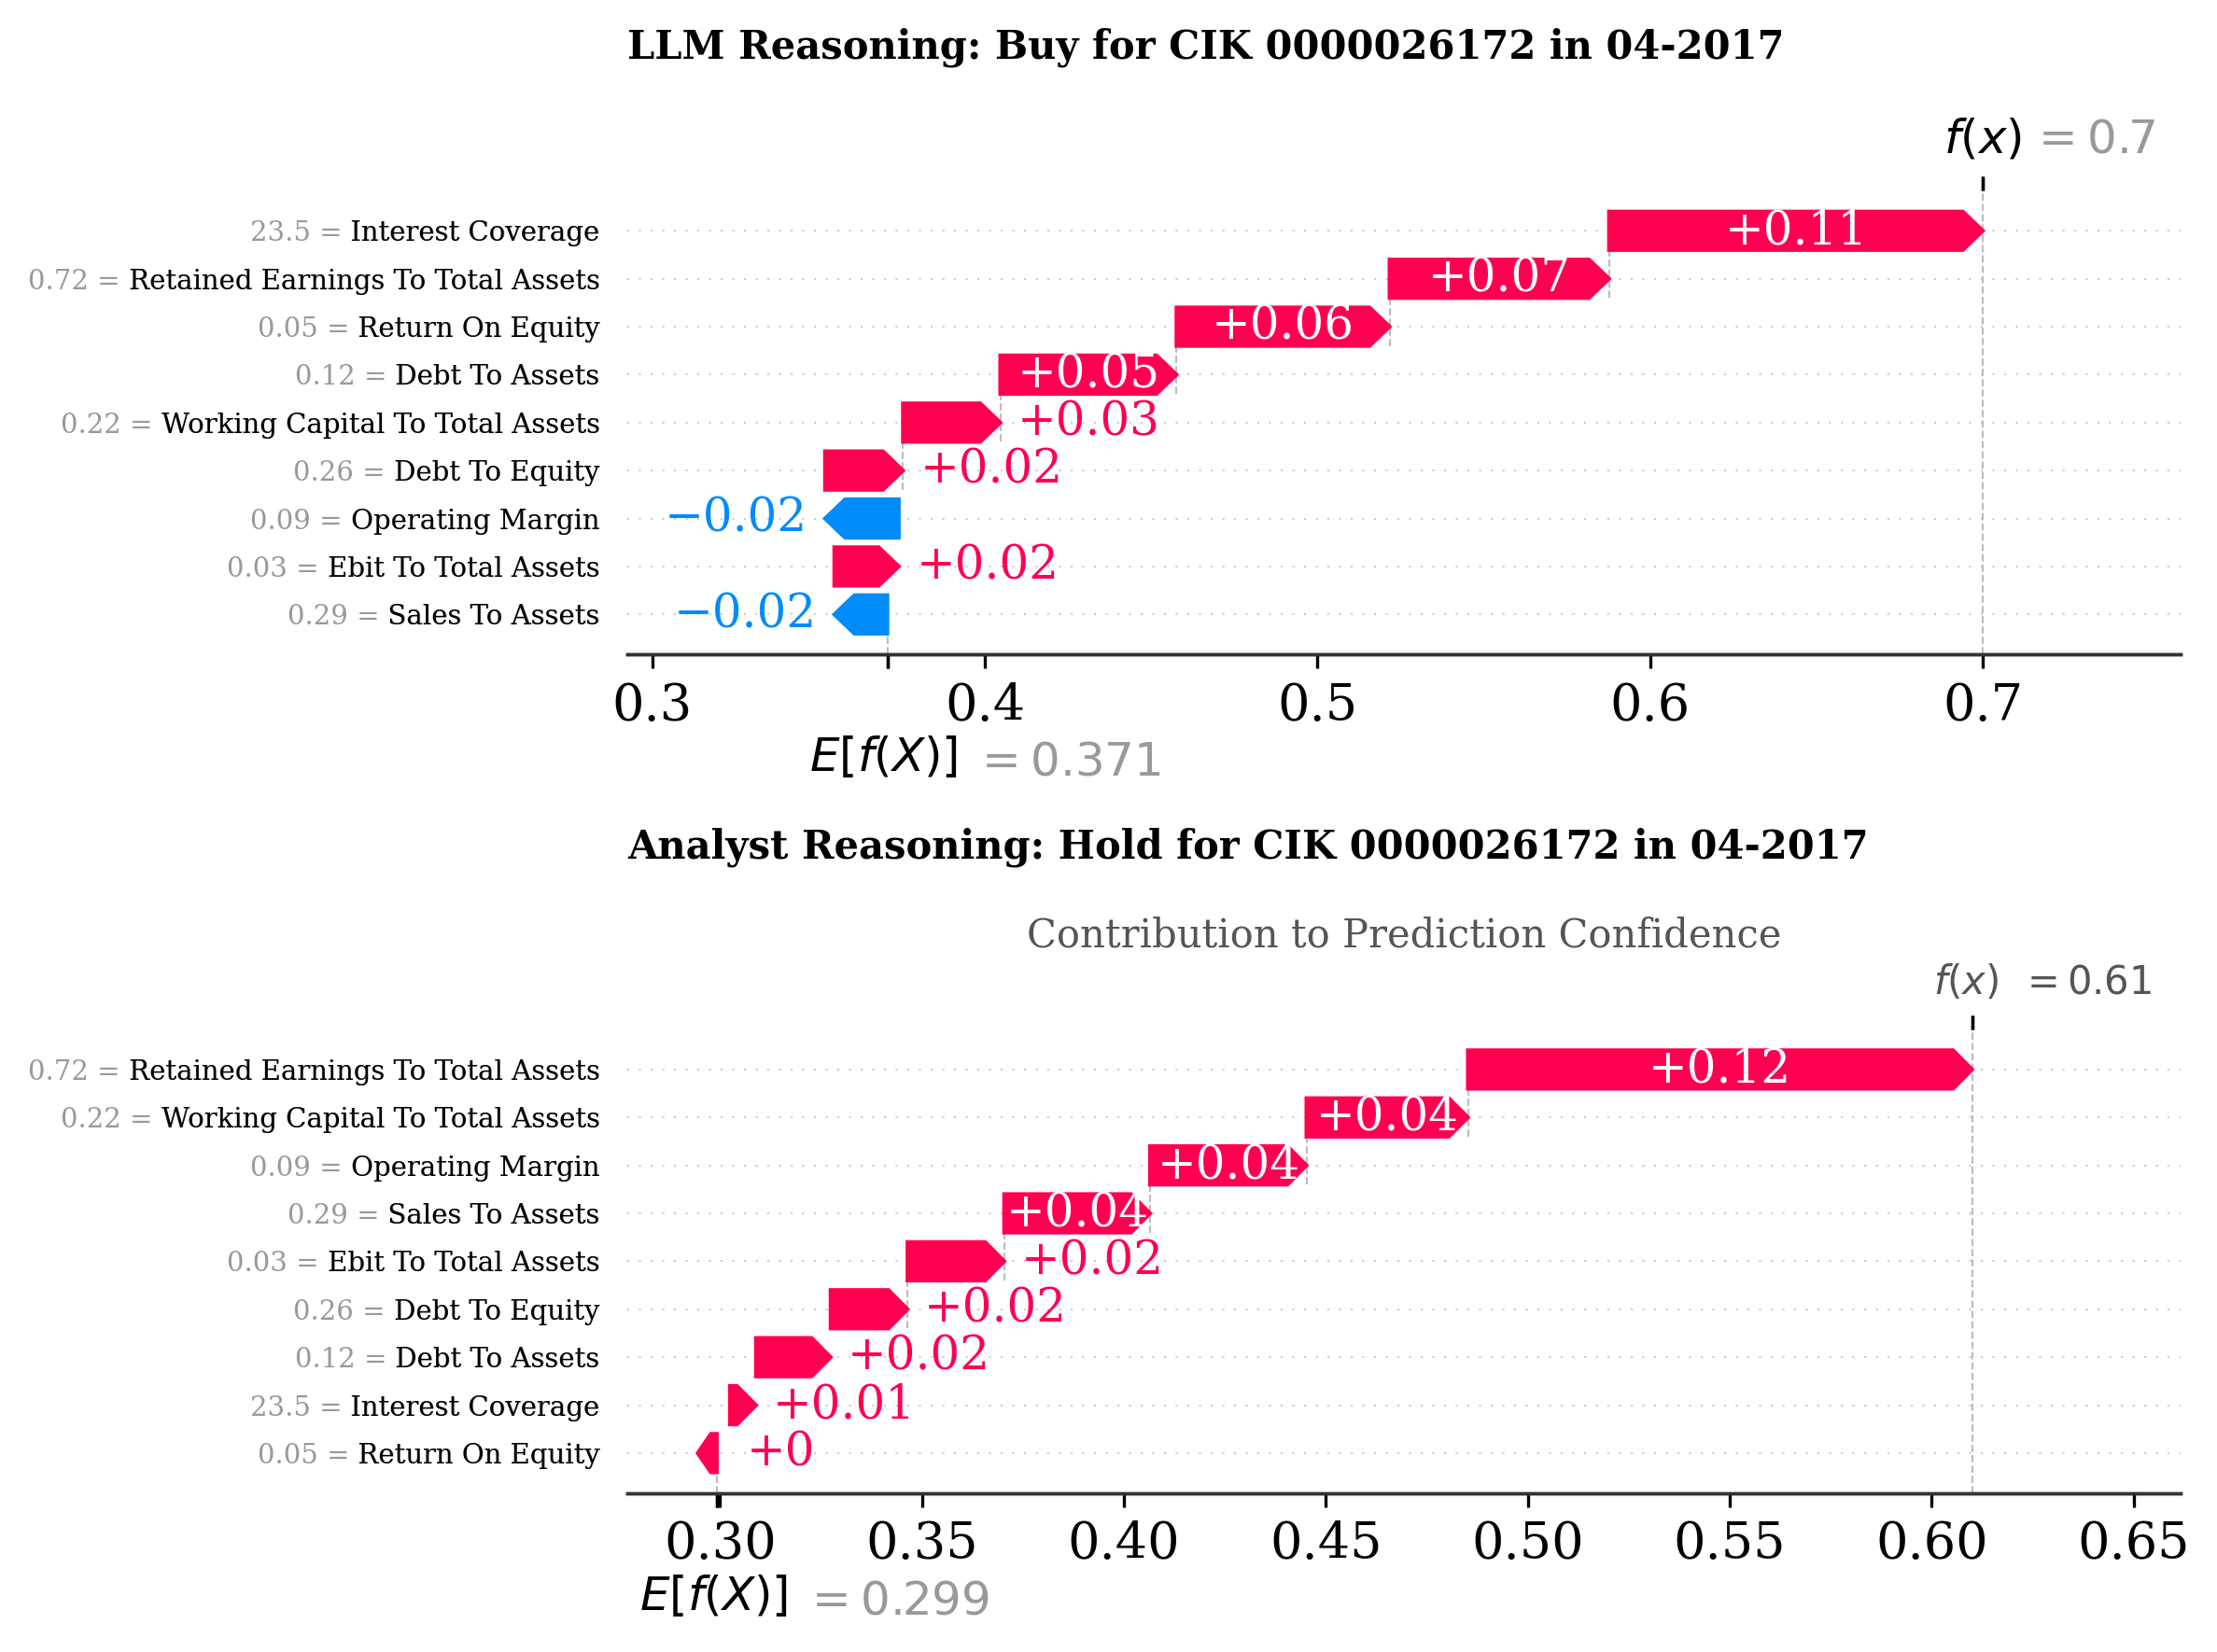

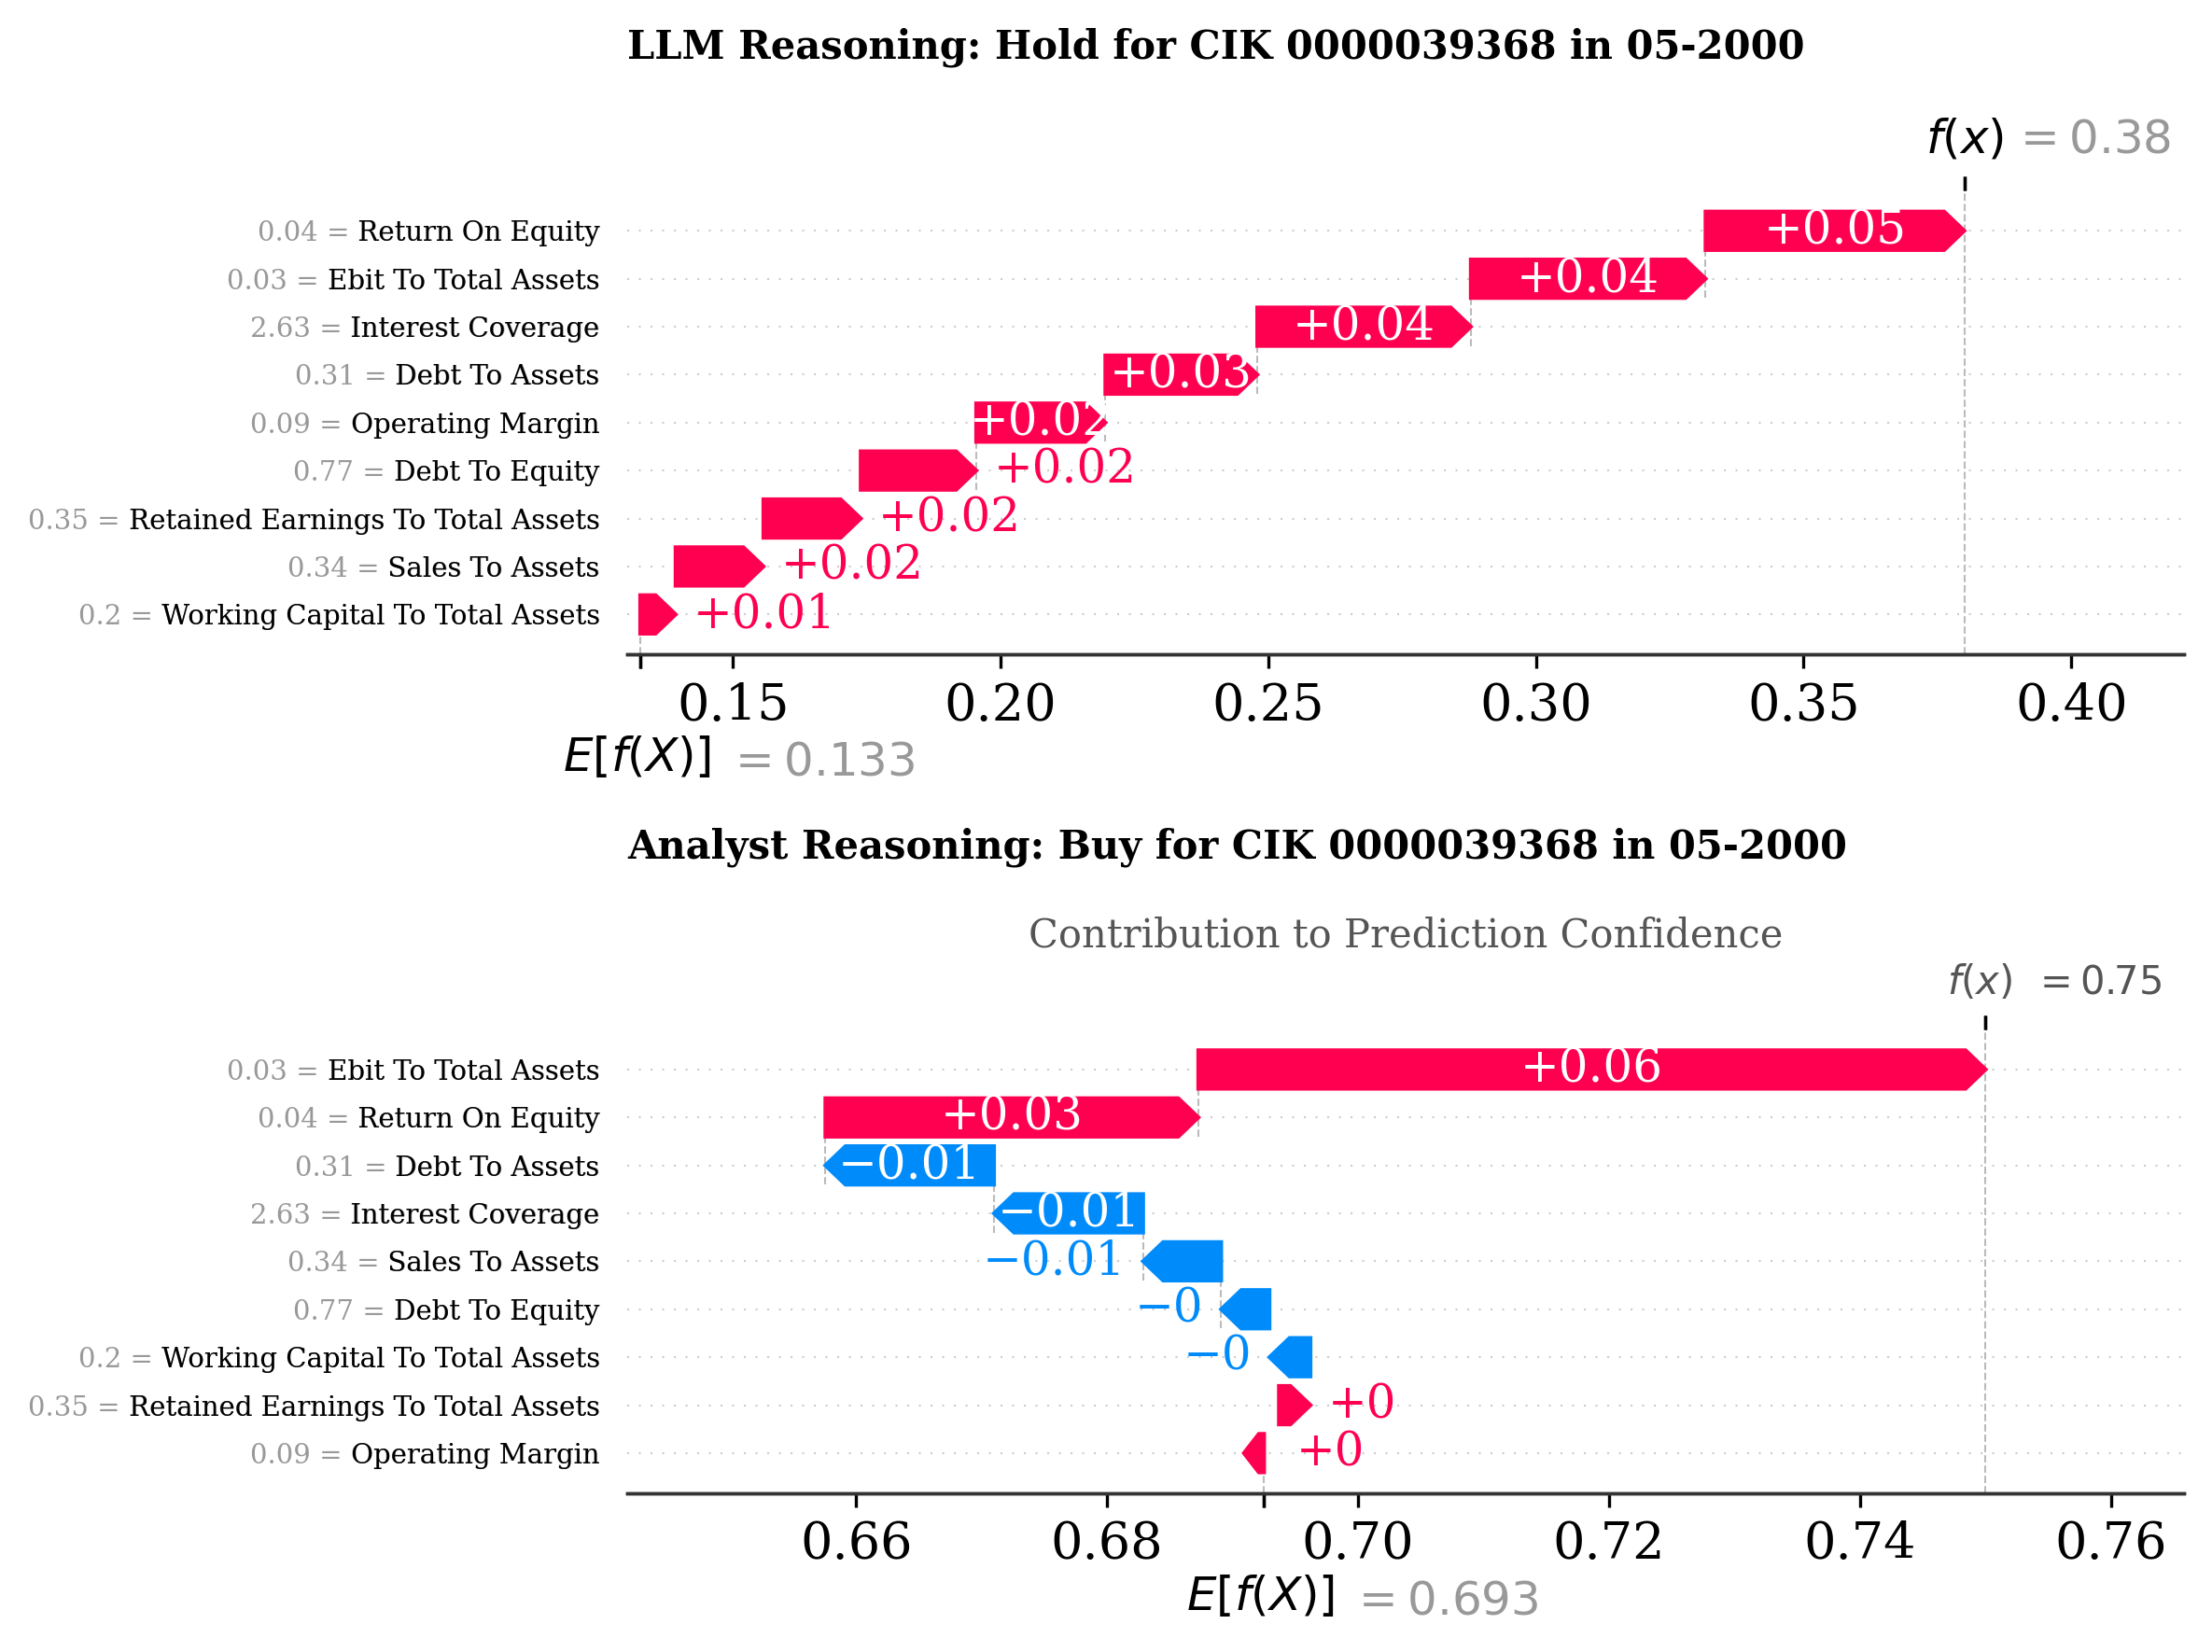

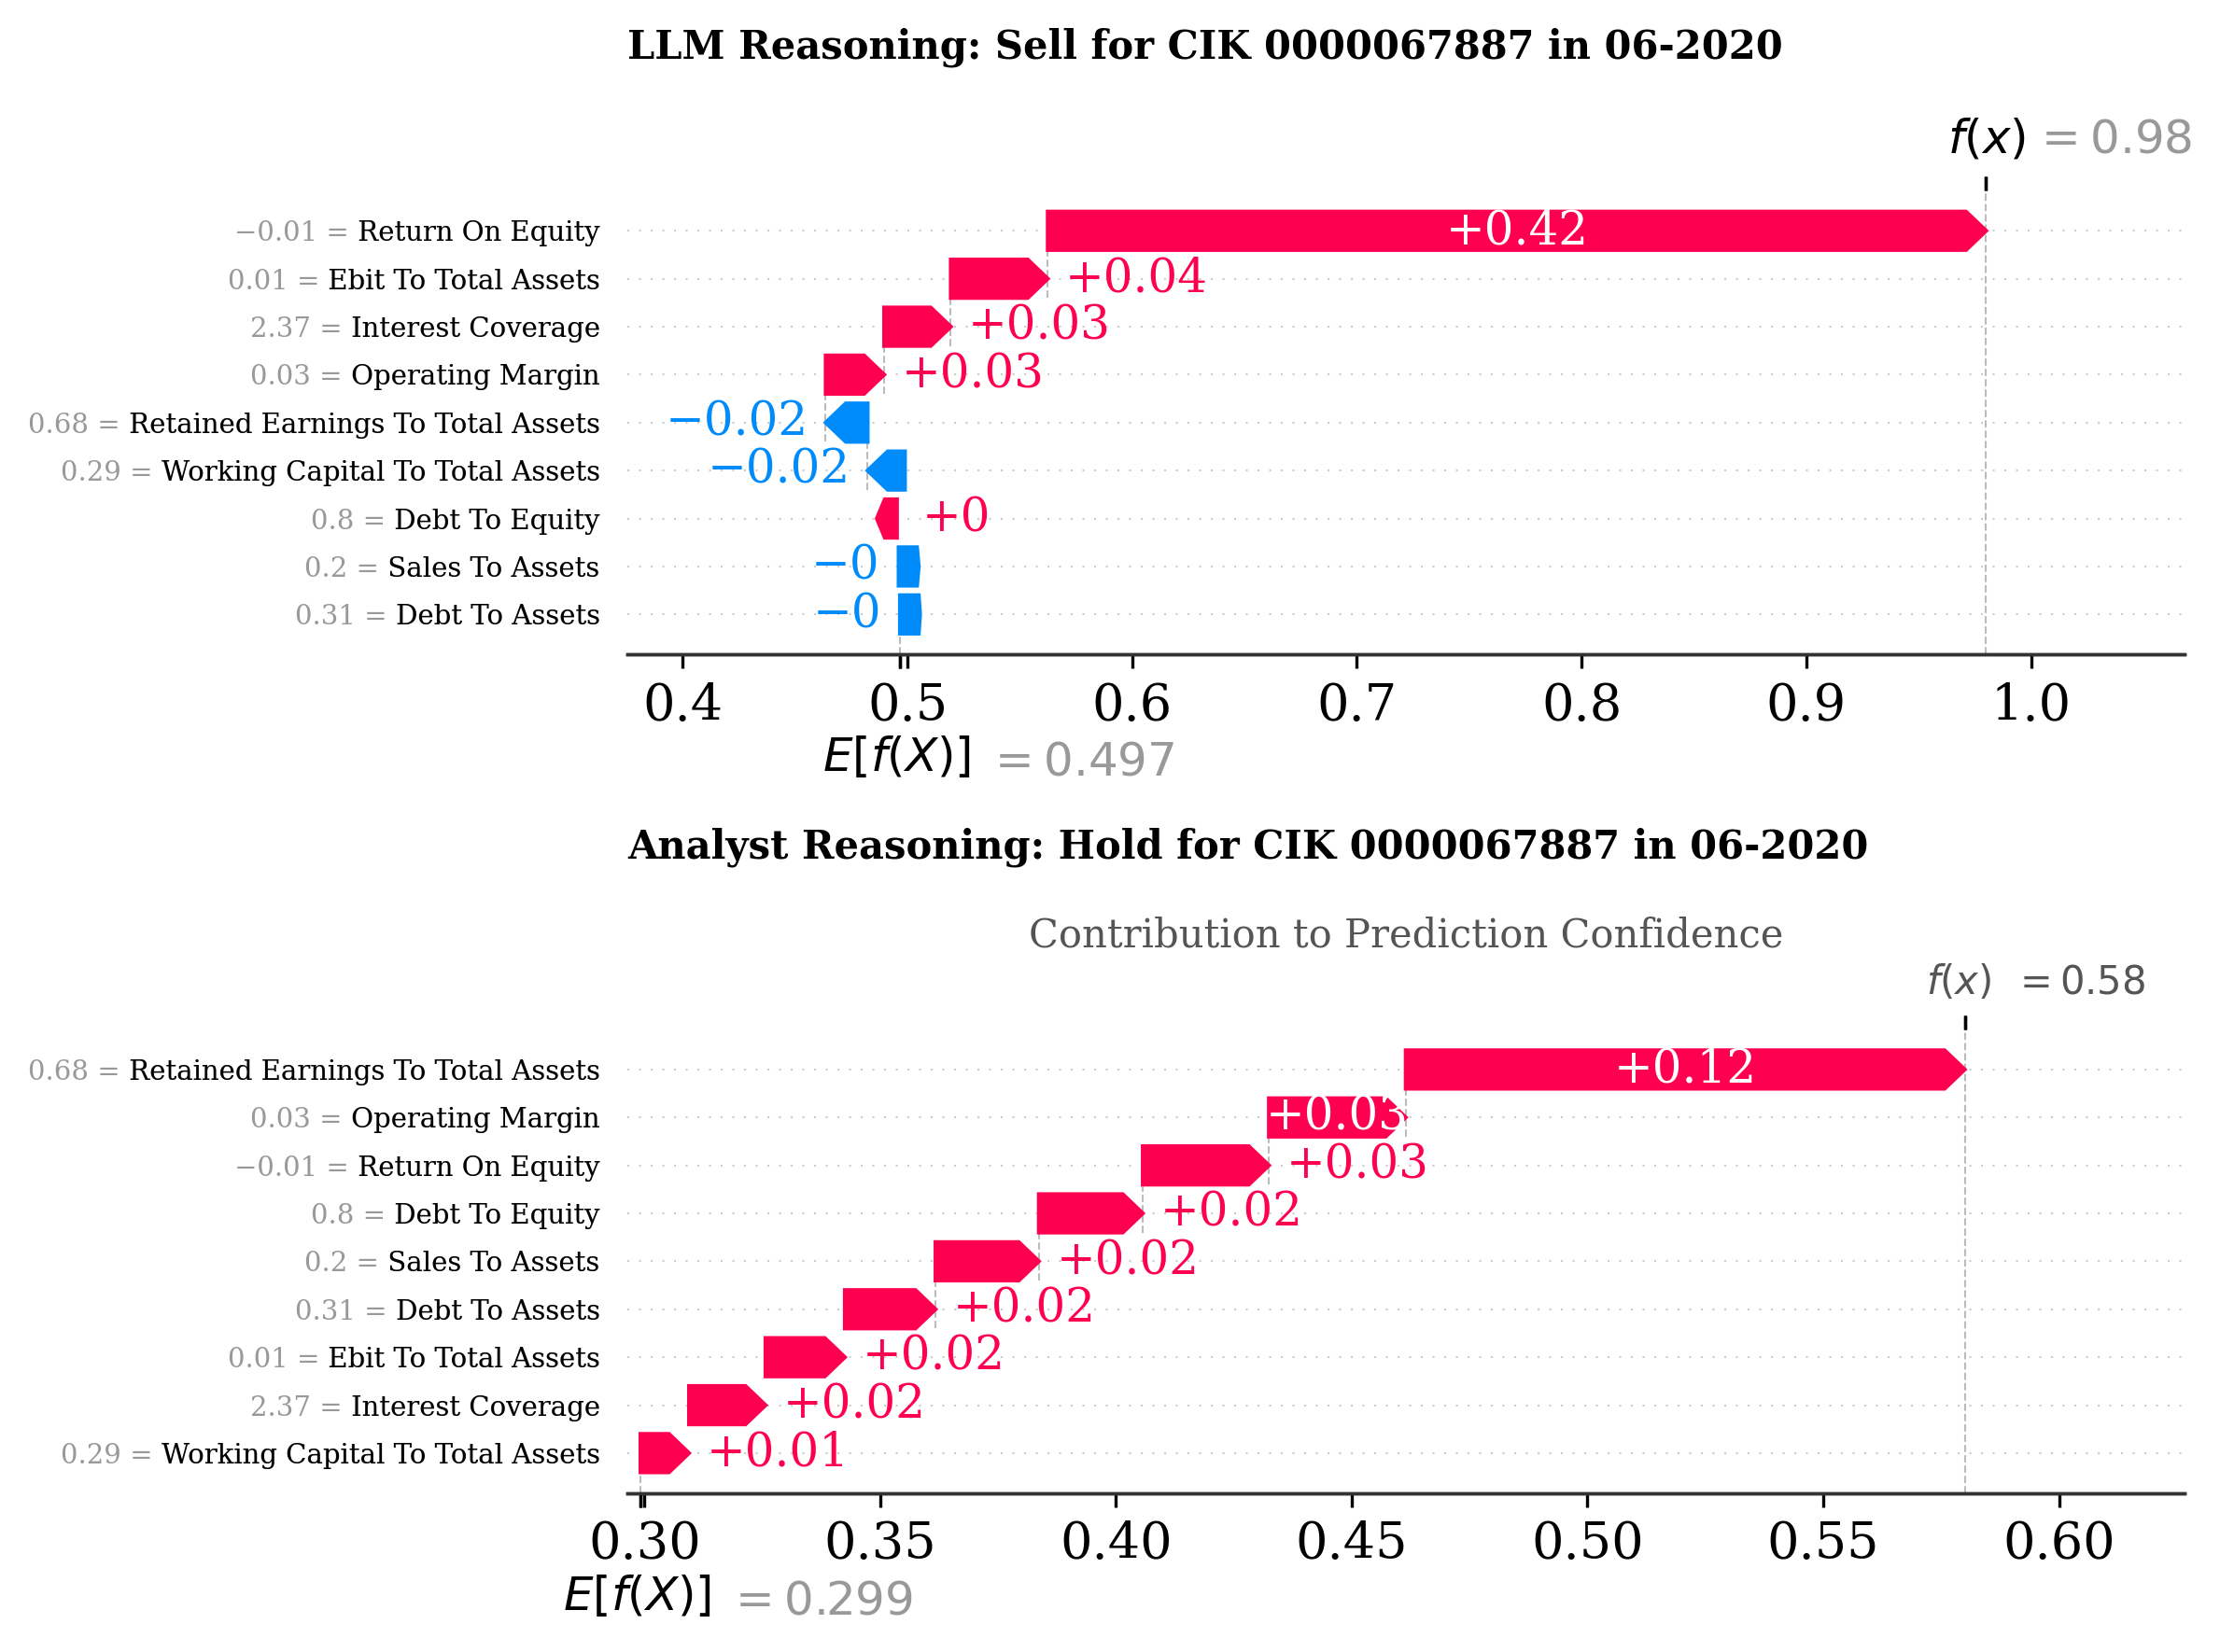

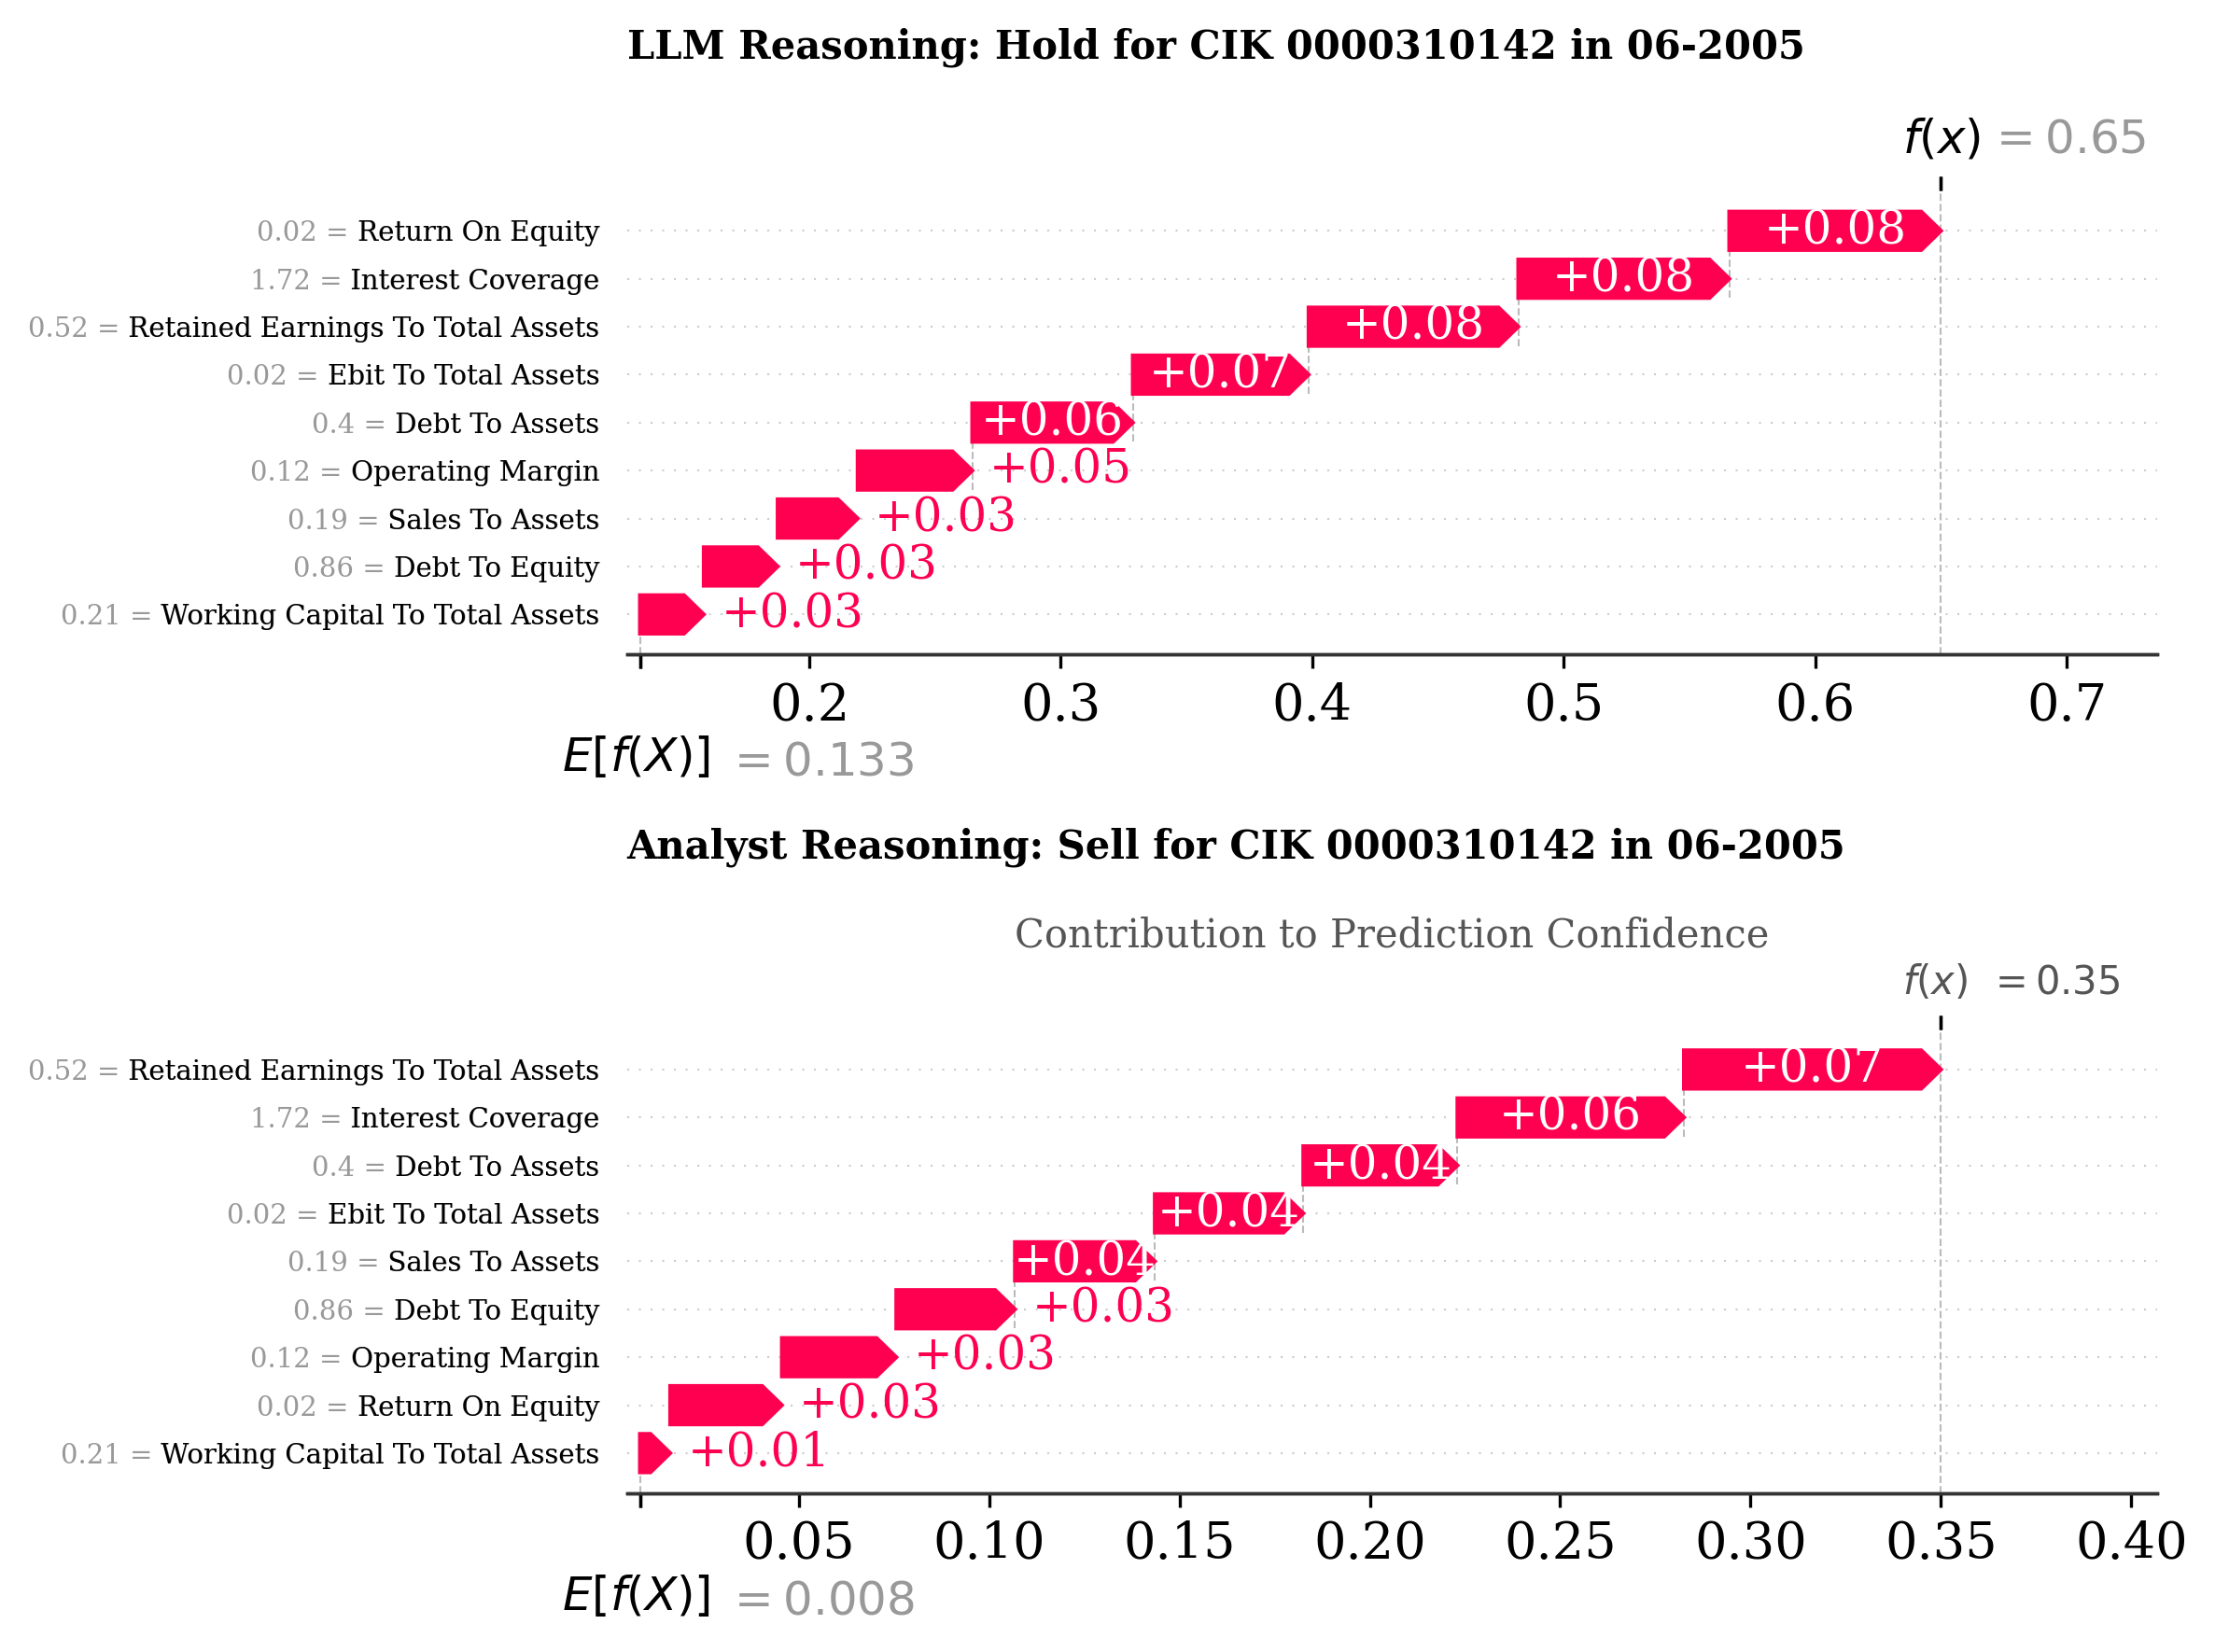

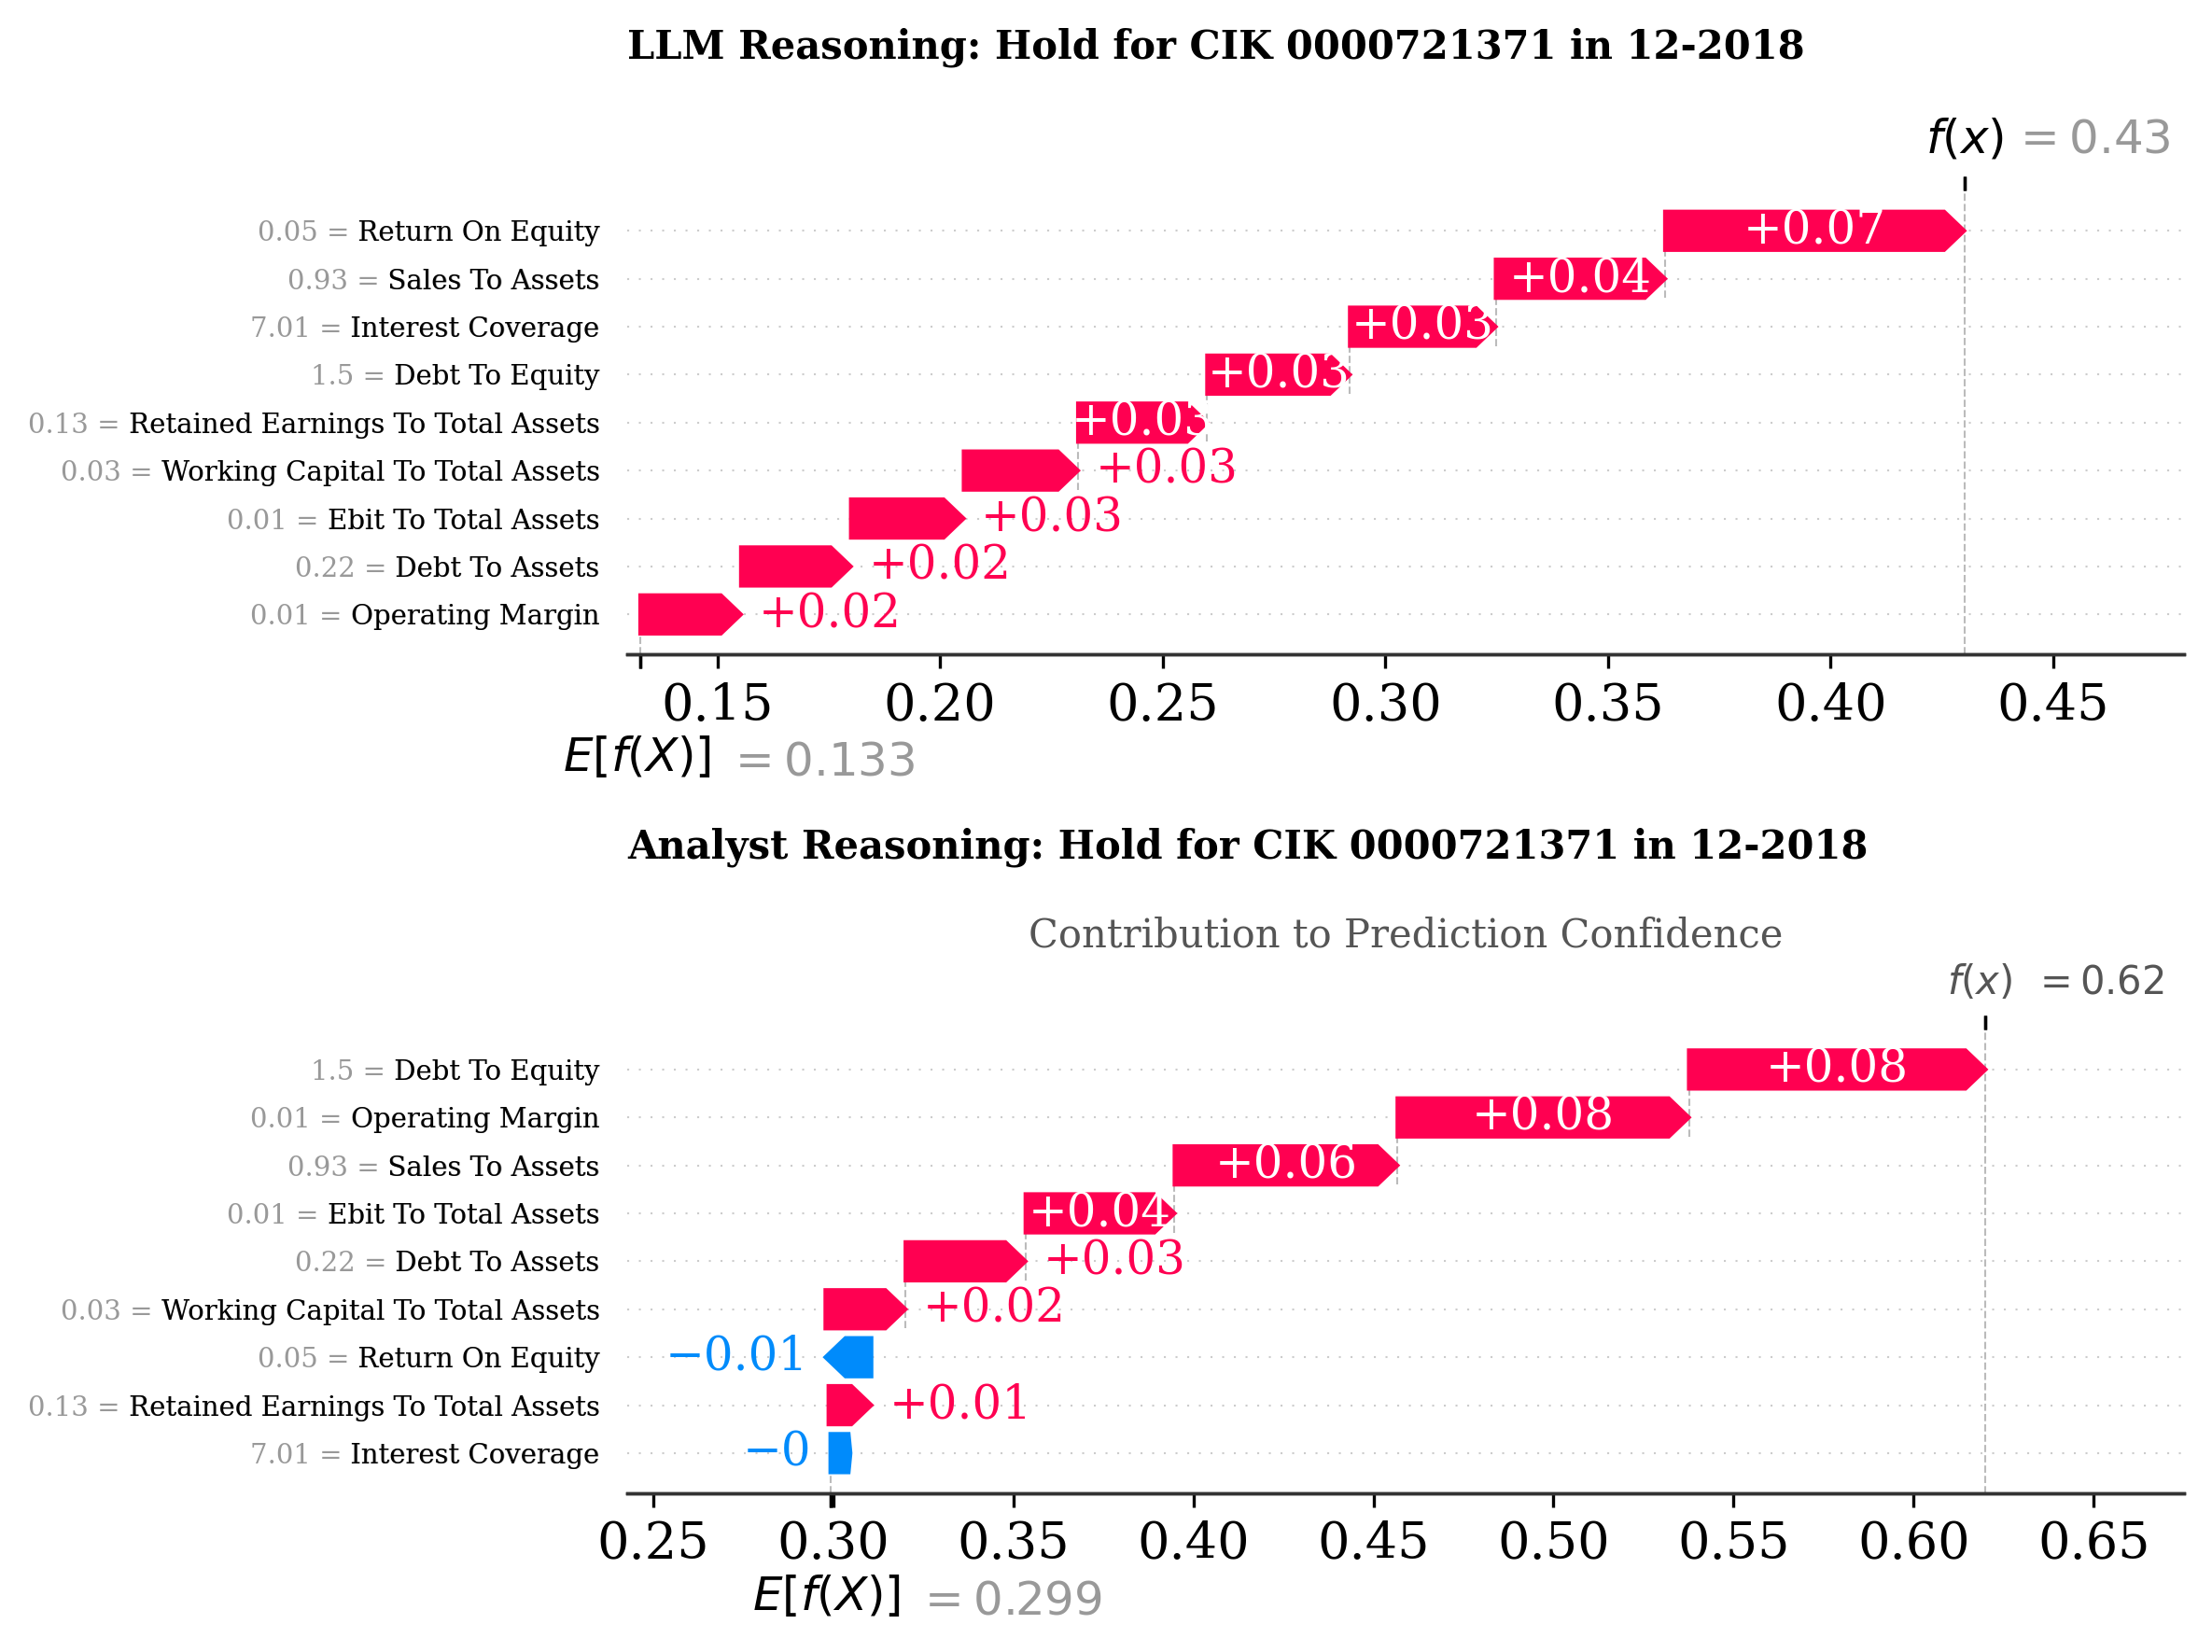

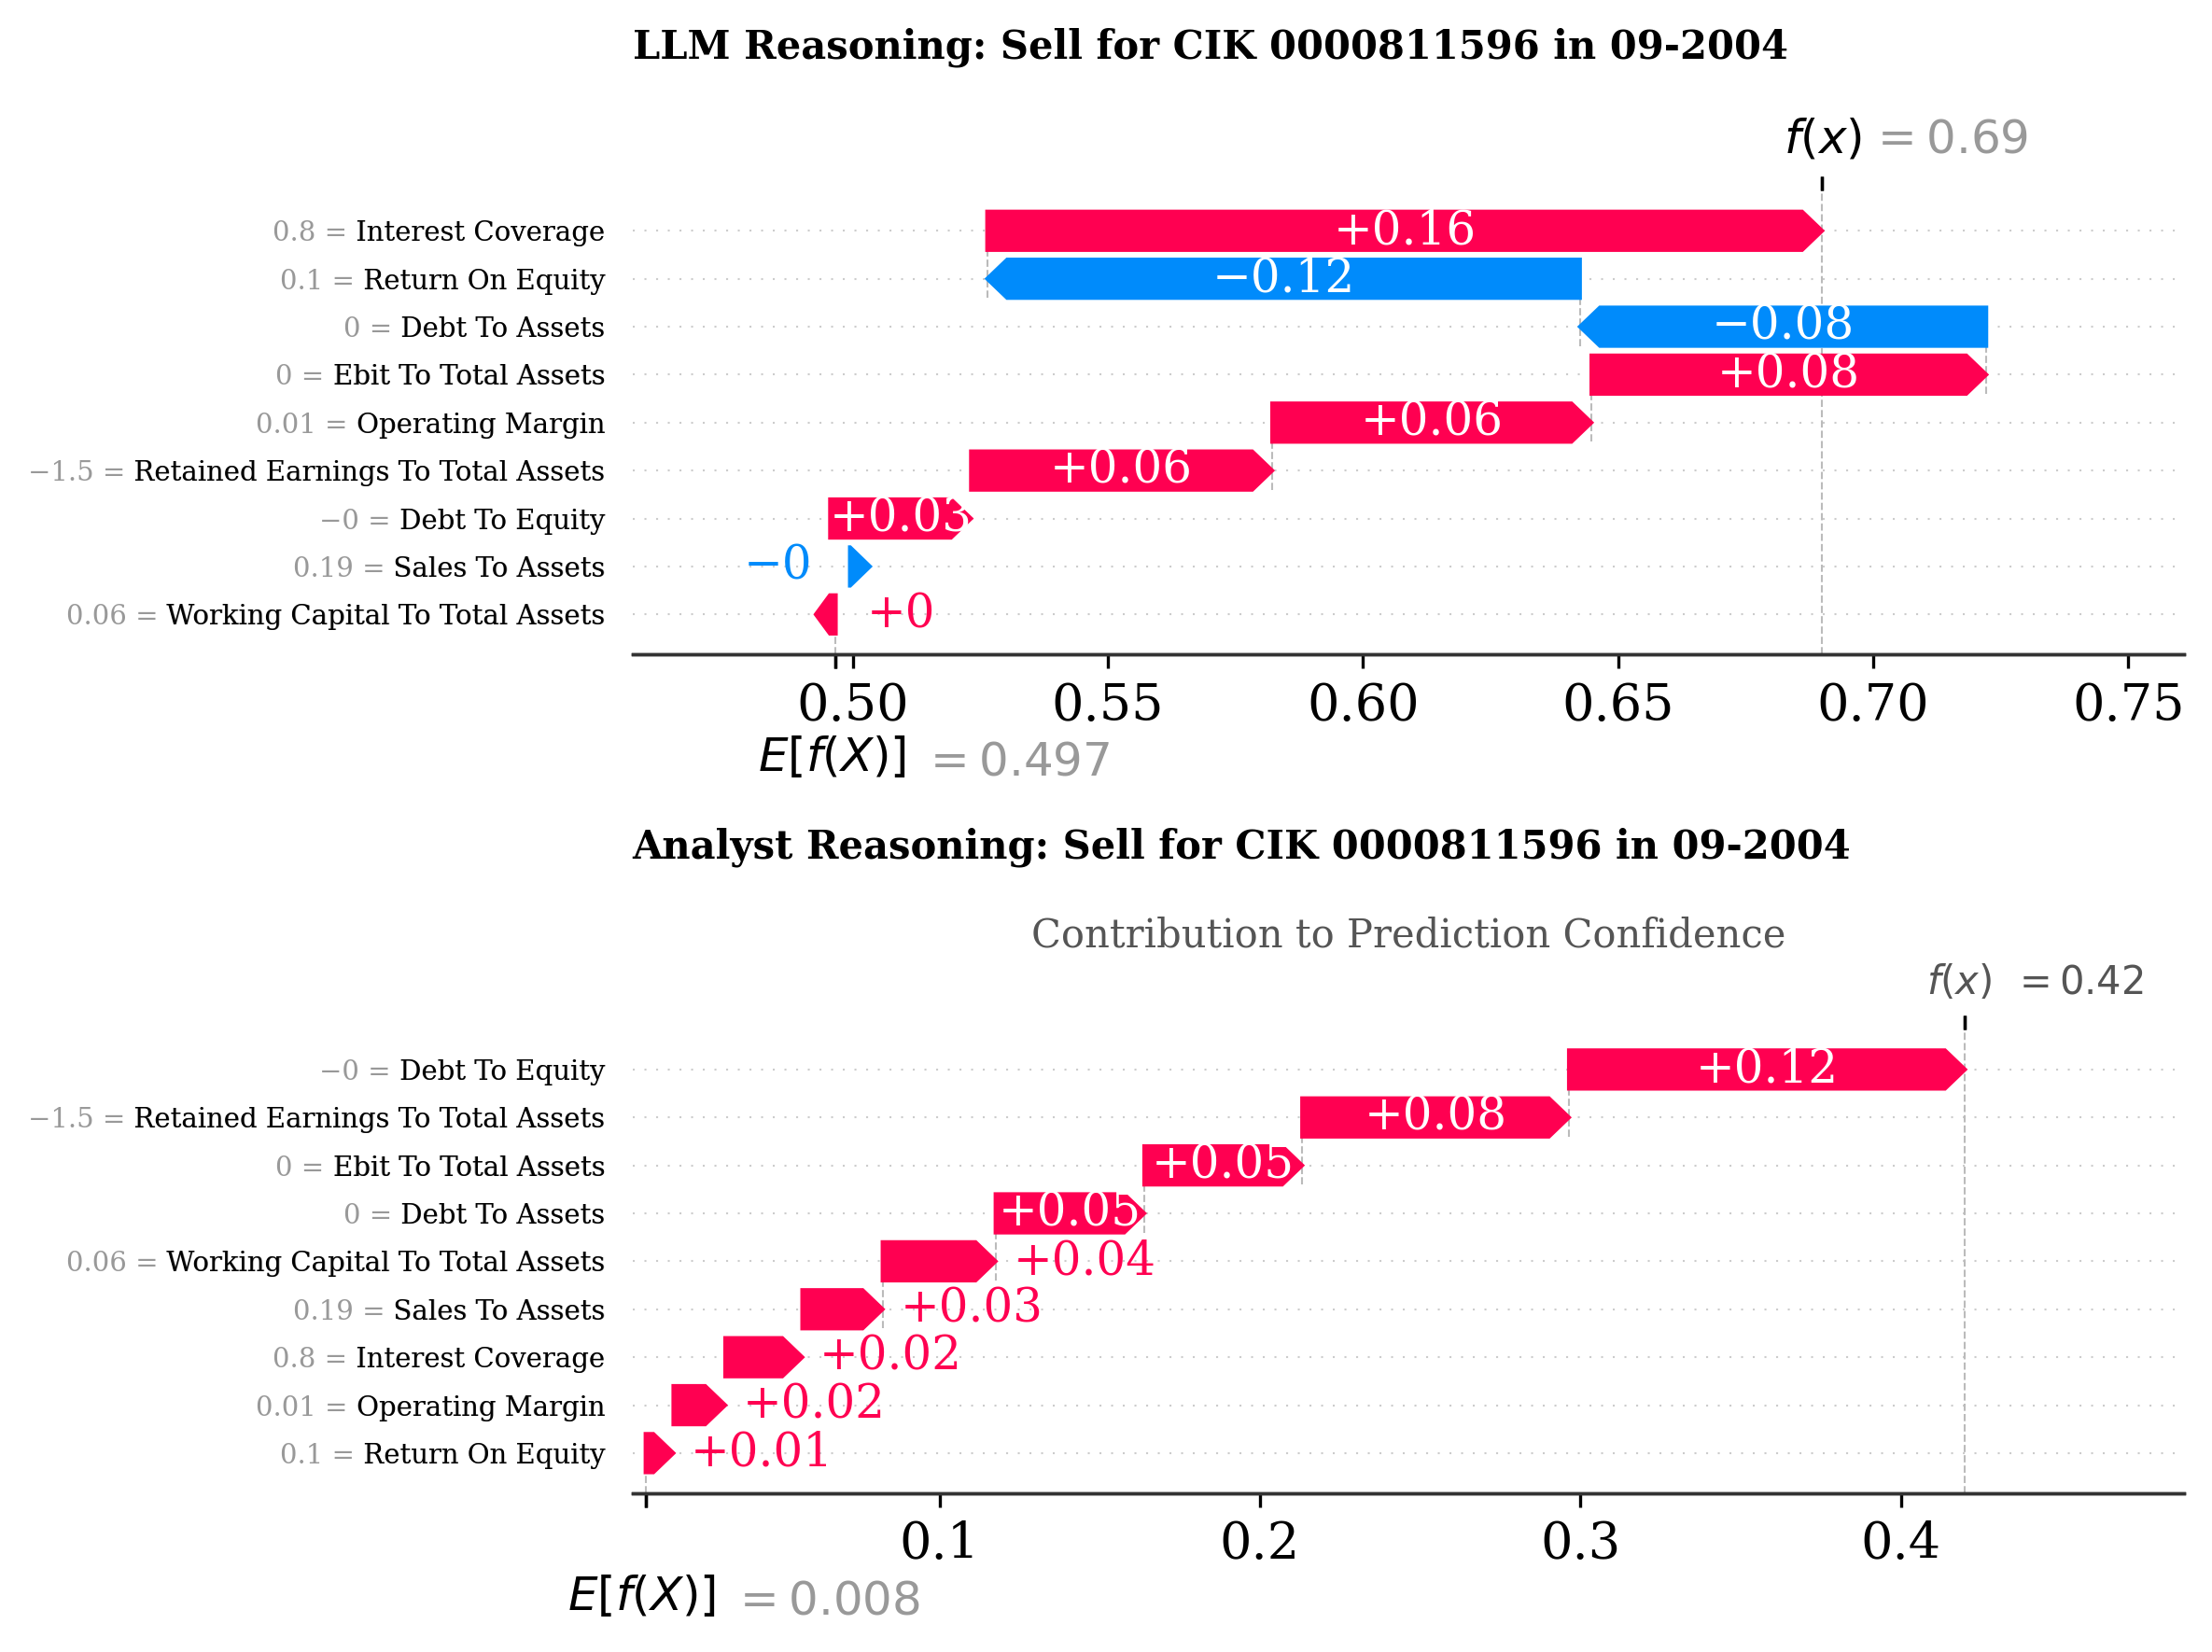

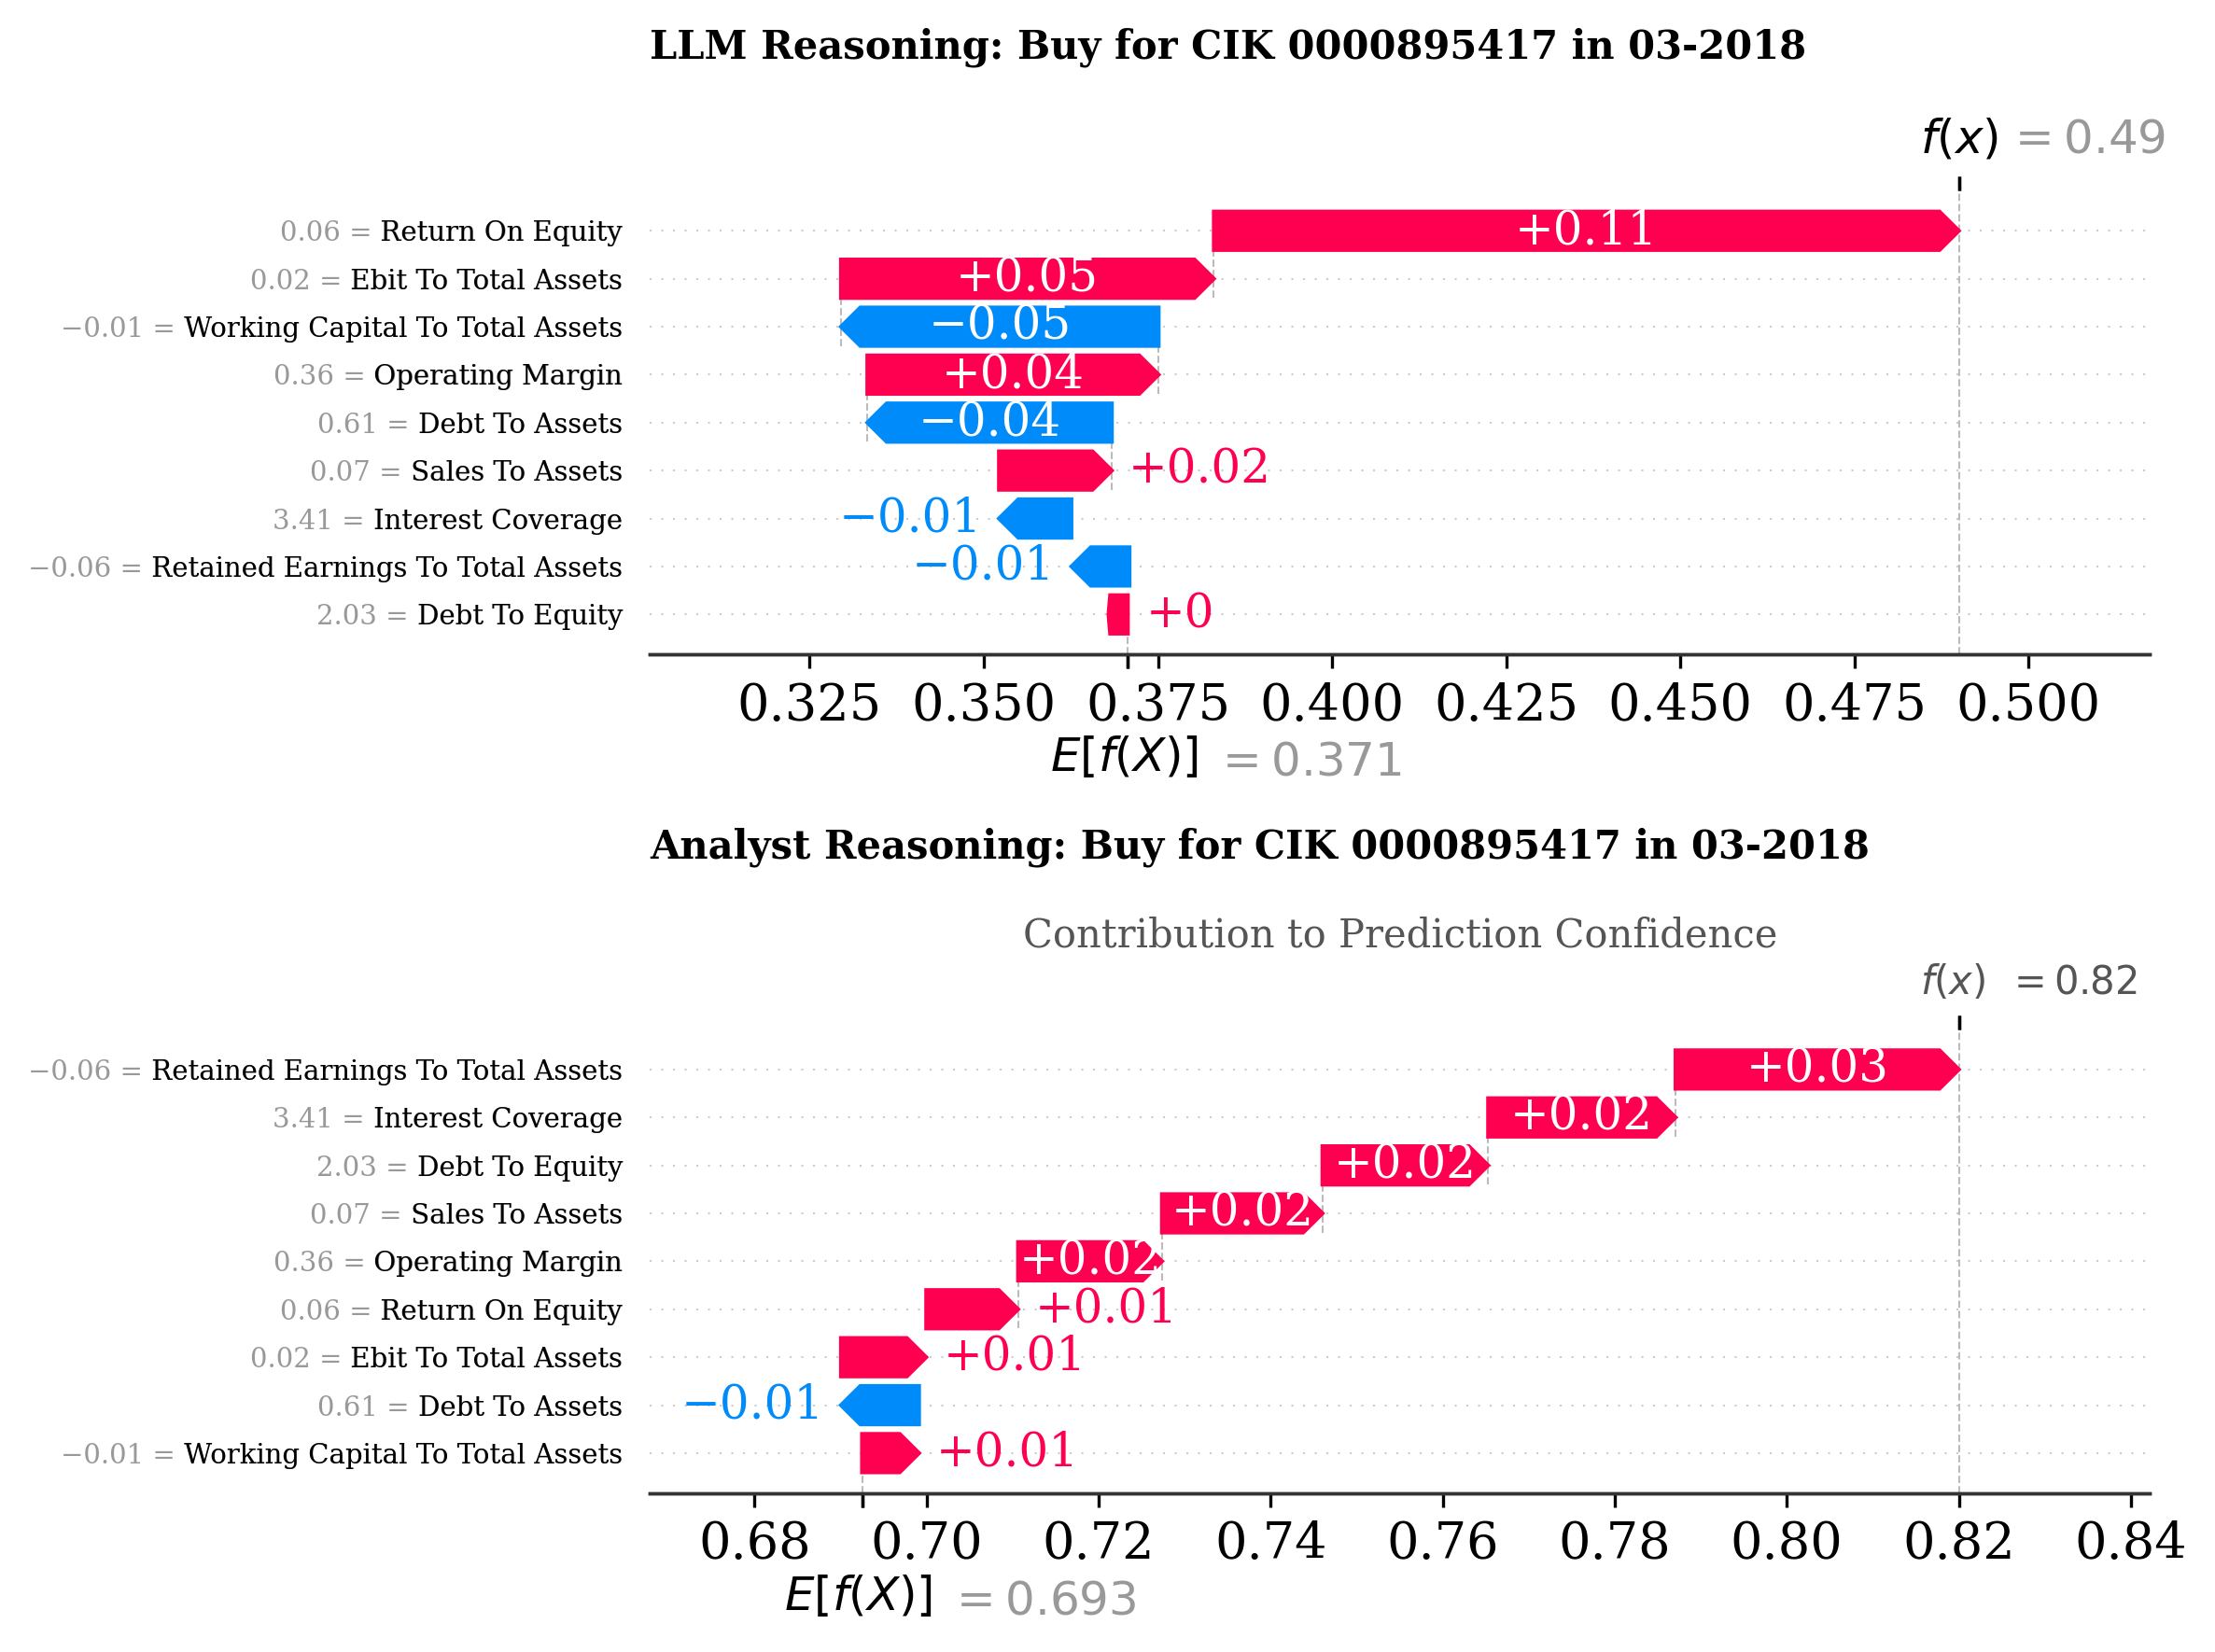

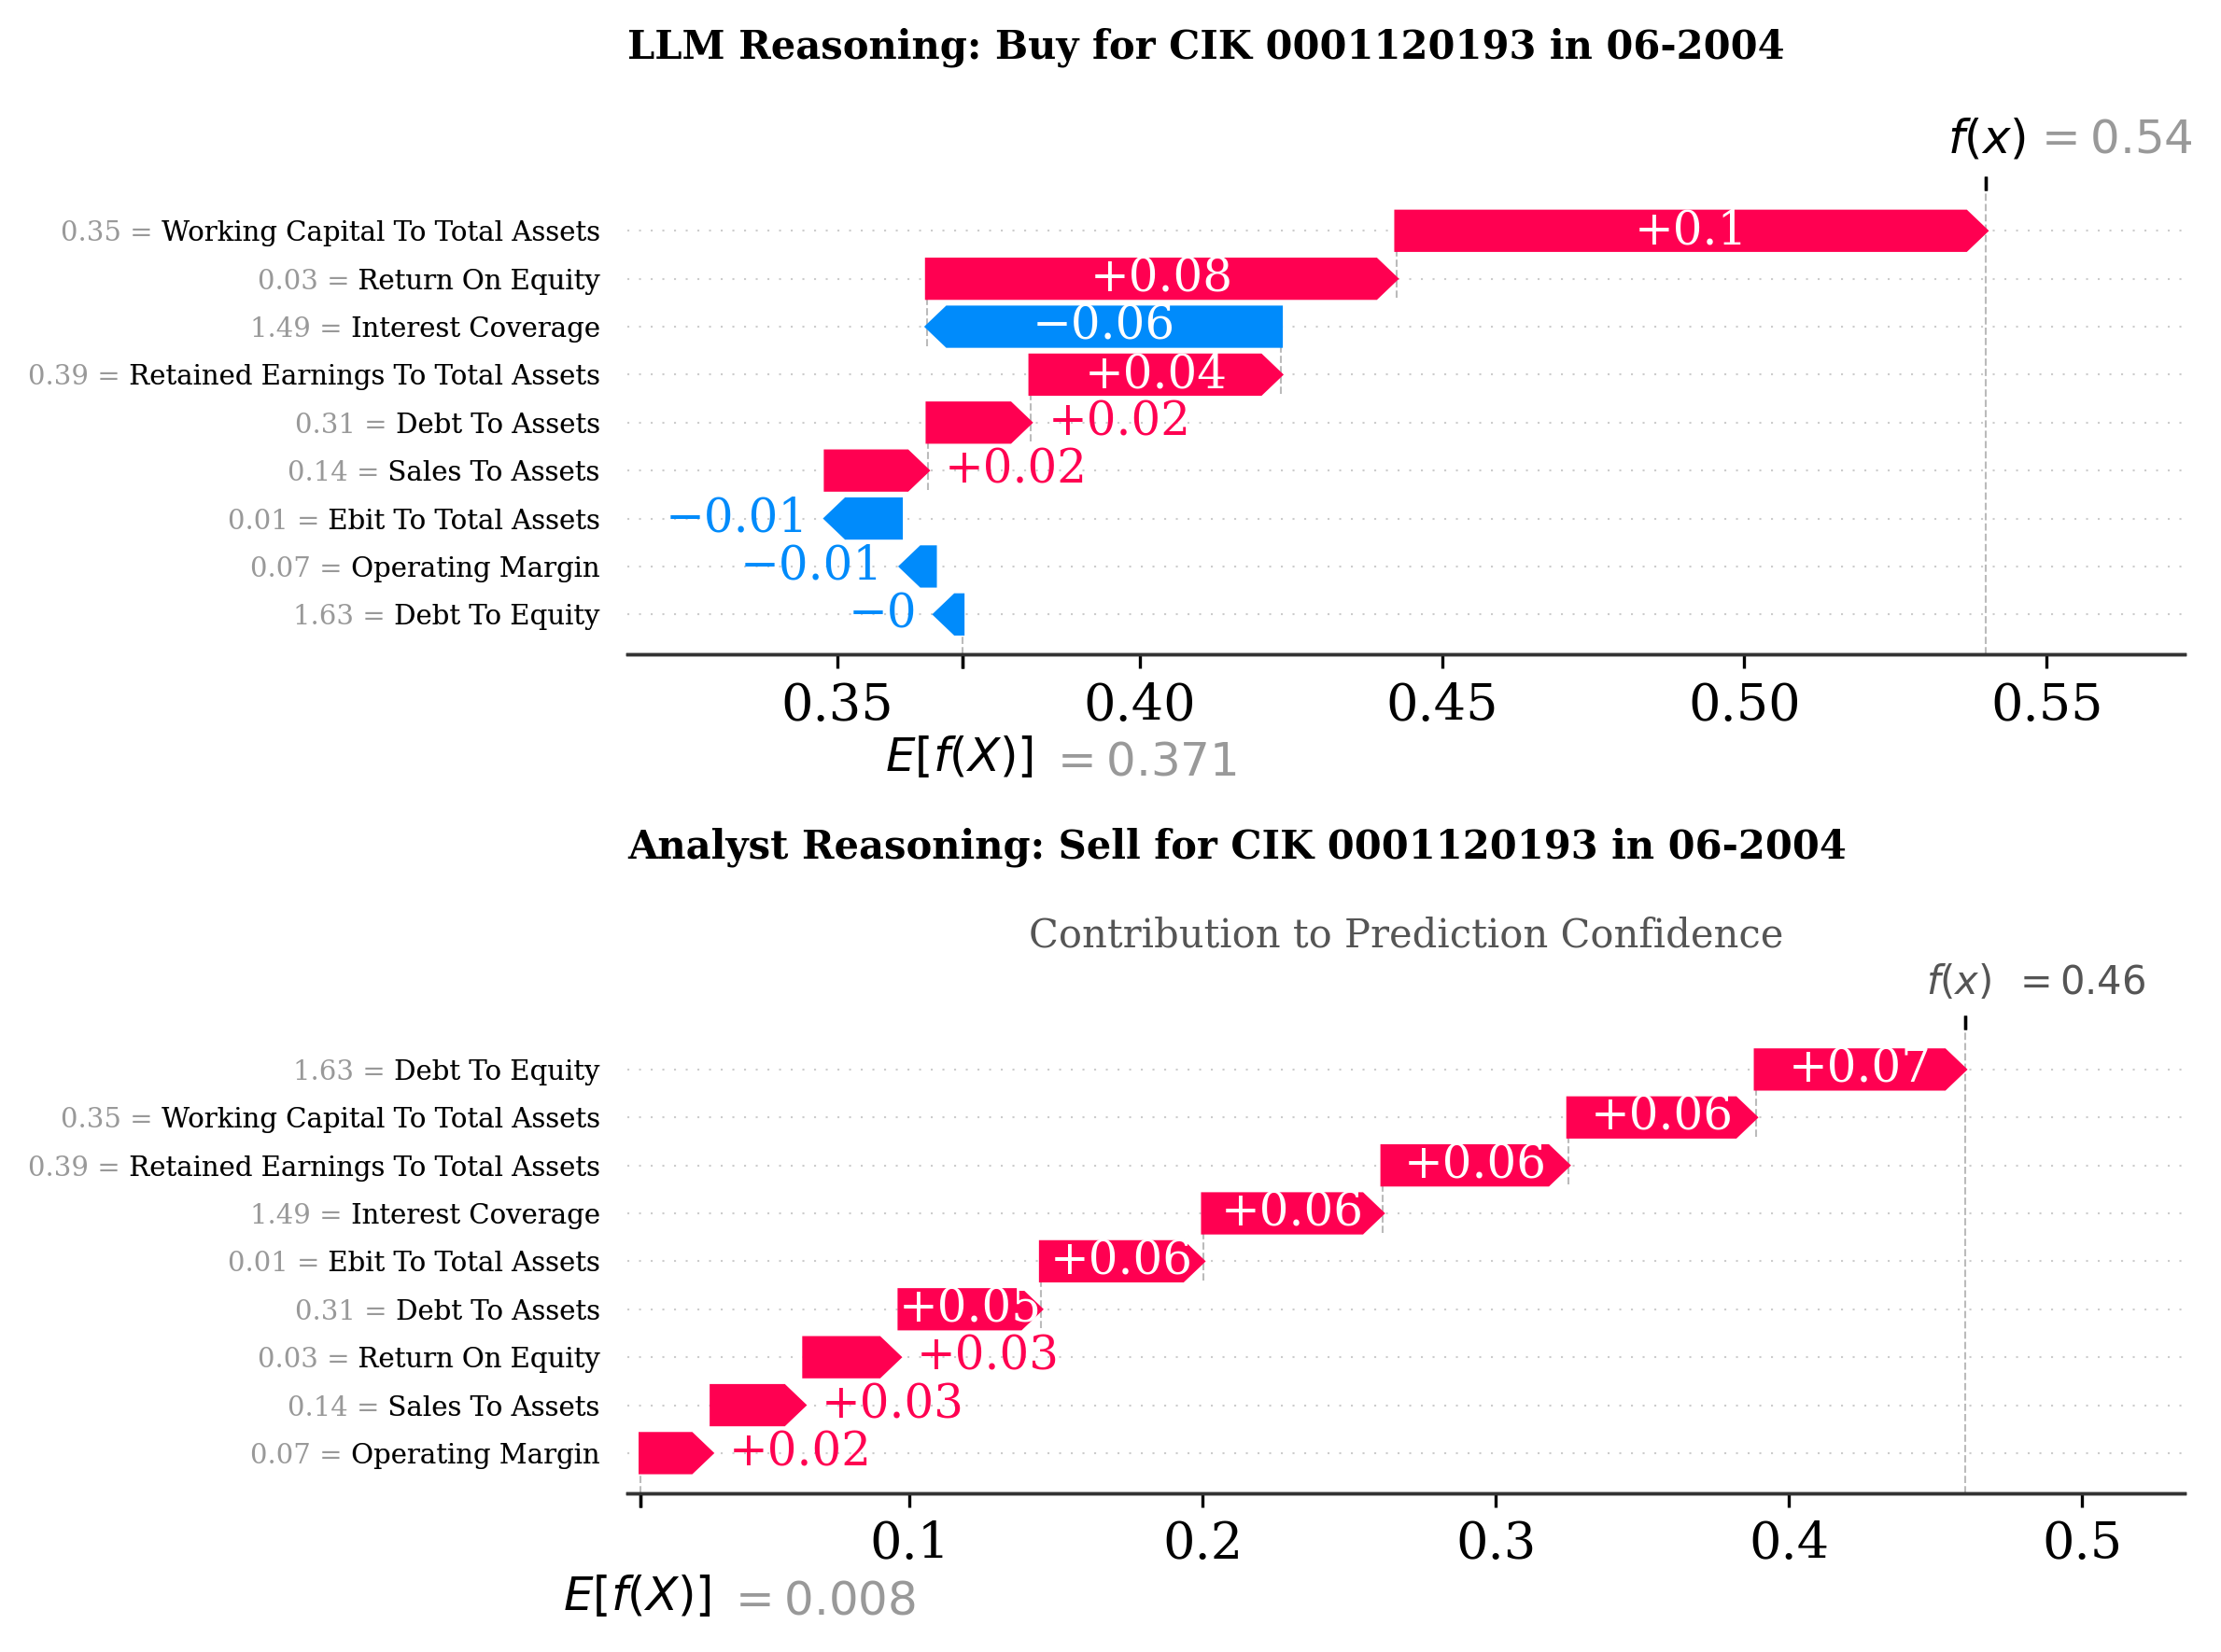

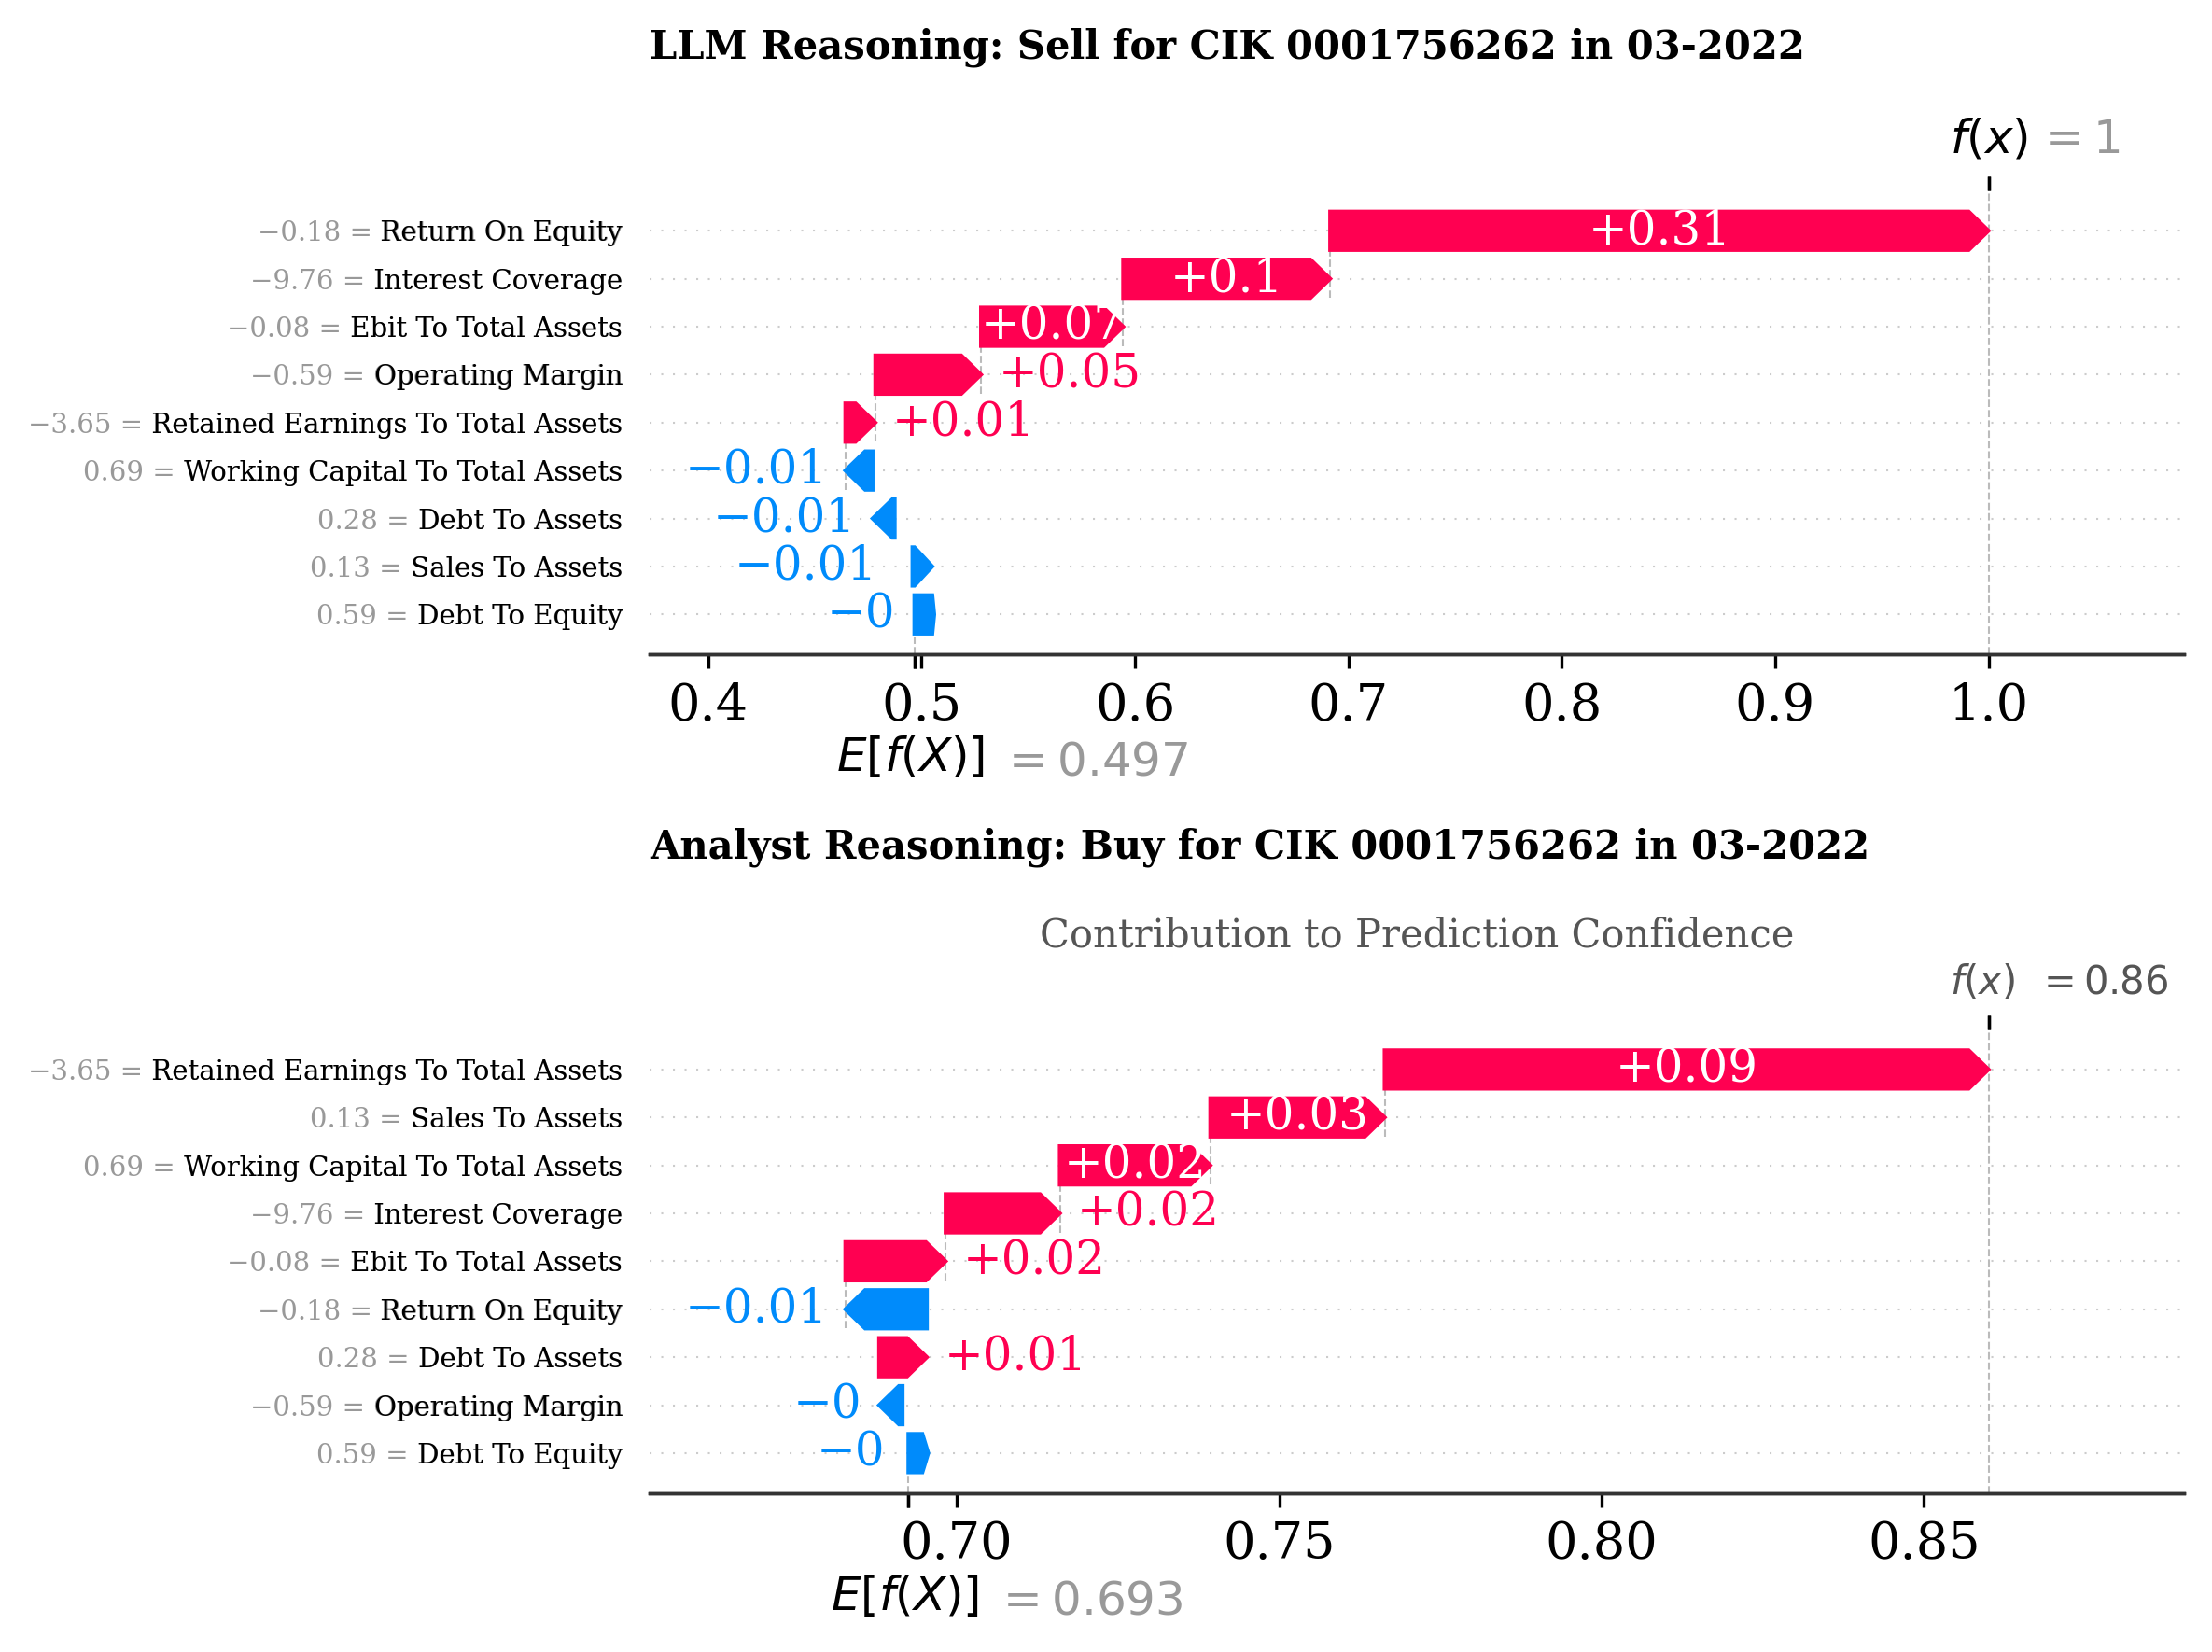

In [ ]:
indices = range(len(llm_shap_samples))
for i in indices:
    plot_waterfall(idx = i, 
                shap_values_llm = sv_llm, shap_values_analyst = sv_analyst,
                input_df = llm_shap_samples, 
                explainer_llm = explainer_llm, explainer_analyst = explainer_analyst, 
                model_classes = rf_llm.classes_)

---

## Next steps

- Compare results i.e. does LLM reasoning from asking directly overlap with what the surrogate RF's explainability models say?   
LLM might be able to give correct recommendations for the wrong reasons. Or it simply makes up reasons when prompted. 
- Look more into different market phases, i.e. bear vs bull markets
- Look into specific stocks singularly and more in-depth